In [1]:
# https://pair-code.github.io/understanding-umap/のjsで書かれた人口データをpythonで再現する
# pair-code.github.io/src/visualizations/demos.js
# toy_comparison_visualization/js/demos.js

In [2]:
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy

In [3]:
def hsl_to_rgb(h, s, l):
    def hue_to_rgb(p, q, t):
        t += 1 if t < 0 else 0
        t -= 1 if t > 1 else 0
        if t < 1/6: return p + (q - p) * 6 * t
        if t < 1/2: return q
        if t < 2/3: p + (q - p) * (2/3 - t) * 6
        return p
    if s == 0:
        r, g, b = l, l, l
    else:
        q = l * (1 + s) if l < 0.5 else l + s - l * s
        p = 2 * l - q
        r = hue_to_rgb(p, q, h + 1/3)
        g = hue_to_rgb(p, q, h)
        b = hue_to_rgb(p, q, h - 1/3)
    return r, g, b

# Scale the given vector.
def scale(vector, a):
    for i in range(len(vector)):
        vector[i] *= a
    return vector

# Add two vectors
def add(a, b):
    n = len(a)
    c = [0] * n
    for i in range(n):
        c[i] = a[i] + b[i]
    return c

# A point with color info.
class Point():
    def __init__(self, coords, color="#3399ee"):
        self.coords = coords
        self.color = color if color else "#3399ee"

# Return a color for the given angle.
def angleColor(t):
    hue = ((300 * t) / (2 * np.pi))
    hue = np.floor(hue) if (hue > 0) else np.ceil(hue)
    return hsl_to_rgb(hue/360, 0.5, 0.5)   # "hsl(" + str(hue) + ",50%,50%)"

# Adds colors to points depending on 2D location of original.
def addSpatialColors(points):
    xCoords = [p.coords[0] for p in points]
    yCoords = [p.coords[1] for p in points]
    minx = min(xCoords)
    miny = min(yCoords)
    maxx = max(xCoords)
    maxy = max(yCoords)
    mulx = 255 / (maxx - minx)
    muly = 255 / (maxy - miny)
    for i in range(len(points)):
        c1 = np.floor(mulx*(xCoords[i] - minx)) if xCoords[i] - minx > 0 else np.ceil(mulx*(xCoords[i] - minx))
        c2 = np.floor(muly*(yCoords[i] - miny)) if yCoords[i] - miny > 0 else np.ceil(muly*(yCoords[i] - miny))
        points[i].color = (20, c1, c2)
    return points

# Convenience function to wrap 2d arrays as Points, using a default
# color scheme.
def makePoints(originals):
    points = list(map(lambda p: Point(p), originals))
    return addSpatialColors(points)

def interpolate(a, b, percent):
    x = []
    for i, val in enumerate(a):
        d = b[i] - val
        x.append(d * percent + val)
    return x

# Create random Gaussian vector.
def normalVector(dim):
    p = [0] * dim
    for j in range(dim):
        p[j] = np.random.normal();
    return p

def multiplyScalar(vector, x):
    return list(map(lambda val: val * x, vector))

def addNoise(vector, x):
    return list(map(lambda val: val + (np.random.rand() * x - x / 2), vector))

def star(n, nArms, dim):
    points = []
    pointsPerArm = np.floor(n / nArms)
    for i in range(nArms):
        color = angleColor((np.pi * 2 * i) / nArms)
        armVector = normalVector(dim)
        for i in range(int(pointsPerArm)):
            percent = i / pointsPerArm
            noise = 0.01
            p = addNoise(multiplyScalar(armVector, percent), noise)
            points.append(Point(p, color))
    return points

def linkedClusters(nClusters, perCluster, perLink, dim): 
    points = []
    centroids = []
    for i in range(nClusters):
        color = angleColor((np.pi * 2 * i) / nClusters)
        centroid = normalVector(dim)
        v = normalVector(dim)
        centroids.append(centroid)
    
        for j in range(perCluster):
            p = addNoise(centroid, 0.2)
            point = Point(p, color)
            points.append(point)

        if (i > 0):
            lastCentroid = centroids[i - 1]
            for i in range(perLink):
                percent = i / perLink;
                p = interpolate(centroid, lastCentroid, percent);
                point = Point(addNoise(p, 0.01), "darkgray")
                points.append(point);      
    return points

# Points in a trefoil knot.
def trefoilData(n):
    points = []
    for i in range(n):
        t = (2 * np.pi * i) / n;
        x = np.sin(t) + 2 * np.sin(2 * t);
        y = np.cos(t) - 2 * np.cos(2 * t);
        z = -np.sin(3 * t);
        point = Point([x, y, z], angleColor(t))
        points.append(point)
    return points

# Points in two unlinked rings.
def unlinkData(n):
    points = [];
    def rotate(x, y, z):
        u = x
        cos = np.cos(0.4)
        sin = np.sin(0.4)
        v = cos * y + sin * z
        w = -sin * y + cos * z
        return [u, v, w]
  
    for i in range(n):
        t = (2 * np.pi * i) / n
        sin = np.sin(t)
        cos = np.cos(t)
        # Ring 1.
        points.append(Point(rotate(cos, sin, 0), "#ff9900"))
        # Ring 2.
        points.append(Point(rotate(3 + cos, 0, sin), "#3399ee"))
    return points

# Points in linked rings.
def linkData(n):
    points = [];
    def rotate(x, y, z):
        u = x
        cos = np.cos(0.4)
        sin = np.sin(0.4)
        v = cos * y + sin * z
        w = -sin * y + cos * z
        return [u, v, w]

    for i in range(n):
        t = (2 * np.pi * i) / n
        sin = np.sin(t)
        cos = np.cos(t)
        # Ring 1.
        points.append(Point(rotate(cos, sin, 0), "#ff9900"))
        # Ring 2.
        points.append(Point(rotate(1 + cos, 0, sin), "#3399ee"))
    return points

# Data in shape of 2D grid.
def gridData(size):
    points = []
    for x in range(size):
        for y in range(size):
            points.append([x, y])
    return makePoints(points)

# Data in a 2D circle, regularly spaced.
def circleData(numPoints):
    points = []
    for i in range(numPoints):
        t = (2 * np.pi * i) / numPoints
        points.append(Point([np.cos(t), np.sin(t)], angleColor(t)))
    return points;

# Random points on a 2D circle.
def randomCircleData(numPoints):
    points = [];
    for i in range(numPoints):
        t = 2 * np.pi * np.random.rand() # MATH.rand()
        points.append(Point([np.cos(t), np.sin(t)], angleColor(t)))
    return points


# Clusters arranged in a circle.
def randomCircleClusterData(numPoints):
    points = []
    for i in range(numPoints):
        t = (2 * np.pi * i) / numPoints; # Math.random()
        color = angleColor(t);
        for j in range(20):
            x = np.cos(t) + 0.01 * np.random.normal()
            y = np.sin(t) + 0.01 * np.random.normal()
            points.append(Point([x, y], color)) 
    return points

# Gaussian cloud, symmetric, of given dimension.
def gaussianData(n, dim):
    points = []
    for i in range(n):
        p = normalVector(dim)
        points.append(Point(p))
    return points

# Elongated Gaussian ellipsoid.
def longGaussianData(n, dim):
    points = []
    for i in range(n):
        p = normalVector(dim)
        for j in range(dim):
            p[j] /= 1 + j
        points.append(Point(p))
    return points


# Two long, linear clusters in 2D.
def longClusterData(n):
    points = []
    s = 0.03 * n
    for i in range(n):
        x1 = i + s * np.random.normal()
        y1 = i + s * np.random.normal()
        points.append(Point([x1, y1], "#3399ee"))
        x2 = i + s * np.random.normal() + n / 5
        y2 = i + s * np.random.normal() - n / 5
        points.append(Point([x2, y2], "#ff9900"))
    return points

# Mutually orthogonal steps.
def orthoCurve(n):
    points = []
    for i in range(n):
        coords = [0] * n
        for j in range(n):
            coords[j] = 1 if j < i else 0
        t = (1.5 * np.pi * i) / n
        points.append(Point(coords, angleColor(t)))
    return points

# Random walk
def randomWalk(n, dim):
    points = []
    current = [0] * dim
    for i in range(dim):
        current[i] = 0
    for i in range(n):
        step = normalVector(dim)
        next = copy.copy(current)
        for j in range(dim):
            next[j] = current[j] + step[j]
        t = (1.5 * np.pi * i) / n
        points.append(Point(next, angleColor(t)))
        current = next
    return points

# Random jump: a random walk with
# additional noise added at each step.
def randomJump(n, dim):
    points = []
    current = [0] * dim
    for i in range(dim):
        current[i] = 0
    for i in range(n):
        step = normalVector(dim)
        next = add(step, copy.copy(current))
        r = normalVector(dim)
        r = scale(r, np.sqrt(dim))
        t = (1.5 * np.pi * i) / n
        coords = add(r, next)
        points.append(Point(coords, angleColor(t)))
        current = next
    return points

# Uniform points from a cube.
def cubeData(n, dim):
    points = [];
    for i in range(n):
        p = [0] * dim
        for j in range(dim):
            p[j] = np.random.rand()
        points.append(Point(p))
    return points

# Data in a rough simplex.
def simplexData(n, noise=0.5):
    noise = (0.5 if noise == False else noise)
    print(noise)
    points = []
    for i in range(n):
        p = [0] * n
        for j in range(n):
            p[j] = 1 + noise * np.random.normal() if i == j else 0
        points.append(Point(p))
    return points

# Two 2D clusters of different sizes.
def twoDifferentClustersData2D(n):
    points = []
    for i in range(n):
        points.append(Point([10 * np.random.normal(), 10 * np.random.normal()], "#3399ee"))
        points.append(Point([100 + np.random.normal(), np.random.normal()], "#ff9900"))
    return points

# Two clusters of the same size.
def twoClustersData(n, dim):
    dim = 50 if dim == False else dim
    points = []
    for i in range(n):
        points.append(Point(normalVector(dim), "#3399ee"))
        v = normalVector(dim)
        v[0] += 10
        points.append(Point(v, "#ff9900"))
    return points

# Two differently sized clusters, of arbitrary dimensions.
def twoDifferentClustersData(n, dim, scale):
    dim = 50 if dim == False else dim
    scale = 10 if scale == False else scale
    points = []
    for i in range(n):
        points.append(Point(normalVector(dim), "#3399ee"))
        v = normalVector(dim)
        for j in range(dim):
            v[j] /= scale
        v[0] += 20
        points.append(Point(v, "#ff9900"))
    return points

# Three clusters, at different distances from each other, in 2D
def threeClustersData2d(n):
    points = []
    for i in range(n):
        points.append(Point([np.random.normal(), np.random.normal()], "#3399ee"))
        points.append(Point([10 + np.random.normal(), np.random.normal()], "#ff9900"))
        points.append(Point([50 + np.random.normal(), np.random.normal()], "#66aa33"))
    return points

# Three clusters, at different distances from each other, in any dimension.
def threeClustersData(n, dim):
    dim = 50 if dim == False else dim
    points = []
    for i in range(n):
        p1 = normalVector(dim)
        points.append(Point(p1, "#3399ee"))
        p2 = normalVector(dim)
        p2[0] += 10
        points.append(Point(p2, "#ff9900"))
        p3 = normalVector(dim)
        p3[0] += 50
        points.append(Point(p3, "#66aa33"))
    return points;

# One tiny cluster inside of a big cluster.
def subsetClustersData(n, dim):
    dim = 2 if dim == False else dim
    points = []
    for i in range(n):
        p1 = normalVector(dim)
        points.append(Point(p1, "#3399ee"))
        p2 = normalVector(dim)
        p2 = scale(p2, 50)
        points.append(Point(p2, "#ff9900"))
    return points

"""
# ctxをpython流に変換する方法が分からなかったので保留中
function drawLine(ctx, angle, nPixels) {
  const center = nPixels / 2;
  const lineDistance = nPixels * 2;

  ctx.fillStyle = "#000";
  ctx.strokeStyle = "#fff";
  ctx.lineWidth = 2;

  ctx.fillRect(0, 0, nPixels, nPixels);

  const dY = Math.sin(angle) * lineDistance;
  const dX = Math.cos(angle) * lineDistance;

  ctx.beginPath();
  ctx.moveTo(center - dX, center - dY);
  ctx.lineTo(center + dX, center + dY);
  ctx.stroke();

  const { data } = ctx.getImageData(0, 0, nPixels, nPixels);
  const pixelData = [];
  for (let j = 0; j < data.length; j += 4) {
    pixelData.push(data[j]);
  }

  return pixelData;
}

export function continuousLineImages(nLines, nPixels = 28) {
  const canvas = createCanvas(nPixels, nPixels);
  const ctx = canvas.getContext("2d");

  const output = [];
  for (let i = 0; i < nLines; i++) {
    const progress = i / nLines;
    const angle = Math.PI * progress;
    const pixelData = drawLine(ctx, angle, nPixels);

    output.push(new Point(pixelData, angleColor(angle)));
  }
  return output;
}

export function clusteredLineImages(
  nLines,
  nClusters,
  noiseParam = 25,
  nPixels = 28
) {
  const canvas = createCanvas(nPixels, nPixels);
  const ctx = canvas.getContext("2d");

  const linesPerCluster = Math.floor(nLines / nClusters);

  const output = [];
  for (let i = 0; i < nClusters; i++) {
    const progress = i / nClusters;

    for (let j = 0; j < linesPerCluster; j++) {
      const noise = Math.random() * (noiseParam / 100) * Math.PI;
      const angle = Math.PI * progress + noise;
      const pixelData = drawLine(ctx, angle, nPixels);
      output.push(new Point(pixelData, angleColor(angle * 2)));
    }
  }
  return output;
}
"""
# { name: "Number of lines", start: 200 },
#       { name: "Pixels per side", start: 28 }
def linePreview(nb_lines, nPixels):
    output = []
    for x in range(nPixels):
        for y in range(nPixels):
            vector = [x, y]
            output.append(Point(vector, "aliceblue" if y == x else "black"))
    return output

def lineClusterPreview(nb_lines, nPixels):
    output = []
    for x in range(nPixels):
        for y in range(nPixels):
            vector = [x, y]
            output.append(Point(vector, "aliceblue" if y == nPixels - x else "black"))
    return output

def sineFrequency(nVectors, vectorSize):
    minFreq = np.pi / (2 * vectorSize)
    maxFreq = np.pi / ((1 / 10) * vectorSize)

    output = []
    for i in range(nVectors):
        progress = i / nVectors
        freq = (maxFreq - minFreq) * progress + minFreq

        vector = []
        for x in range(vectorSize):
            vector.append(np.sin(freq * x))
        output.append(Point(vector, angleColor(np.pi * 2 * progress)))
    return output


def sinePhase(nVectors, vectorSize):
    freq = (2 * np.pi) / vectorSize
    phase = vectorSize / nVectors

    output = []
    for i in range(nVectors):
        progress = i / nVectors
        phaseOffset = phase * progress

        vector = []
        for x in range(vectorSize):
            vector.append(np.sin(freq * (x + phaseOffset)))
        output.append(Point(vector, angleColor(np.pi * 2 * progress)))
    return output

def sinePreview(nPoints, angle):
    amplitude = nPoints / 2
    freq = np.pi / (nPoints / 5)

    output = []
    for x in range(nPoints):
        progress = x / nPoints
        vector = [x, np.sin(freq * x) * amplitude]
        output.append(Point(vector, angleColor(angle)))
    return output

def sineFreqPreview(nPoints):
    return sinePreview(nPoints, 0)

def sinePhasePreview(nPoints):
    return sinePreview(nPoints, np.pi / 2)

(300, 3)


<IPython.core.display.Javascript object>


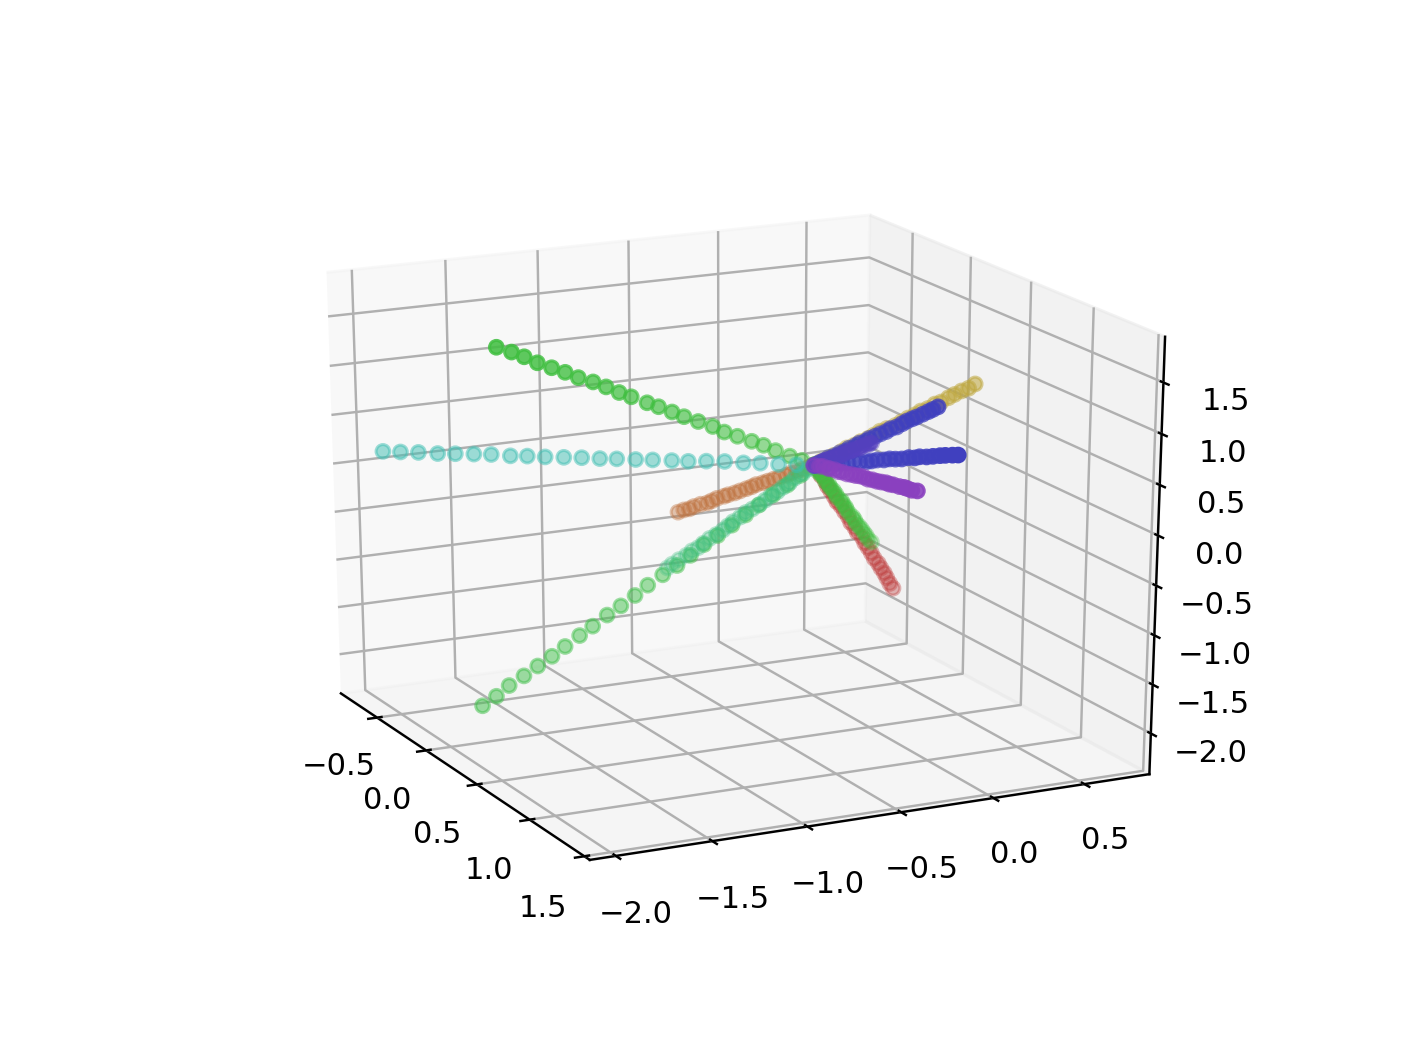

In [4]:
"""
name: "Star",
    description: "Points arranged in a radial star pattern",
    options: [
      {
        name: "Number of points",
        min: 10,
        max: 300,
        start: 100
      },
      {
        name: "Number of arms",
        min: 3,
        max: 20,
        start: 5
      },
      {
        name: "Dimensions",
        min: 3,
        max: 50,
        start: 10
      }
    ],
    generator: generators.star

name: "Star",
    options: [
      { name: "Number of points", start: 300 },
      { name: "Number of arms", start: 12 },
      { name: "Dimensions", start: 10 }
      
"""
points = star(300, 12, 3)
data = np.array(list(map(lambda point: point.coords, points)))
color = np.array(list(map(lambda point: point.color, points)))
print(data.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], color=color)
plt.show()

<IPython.core.display.Javascript object>


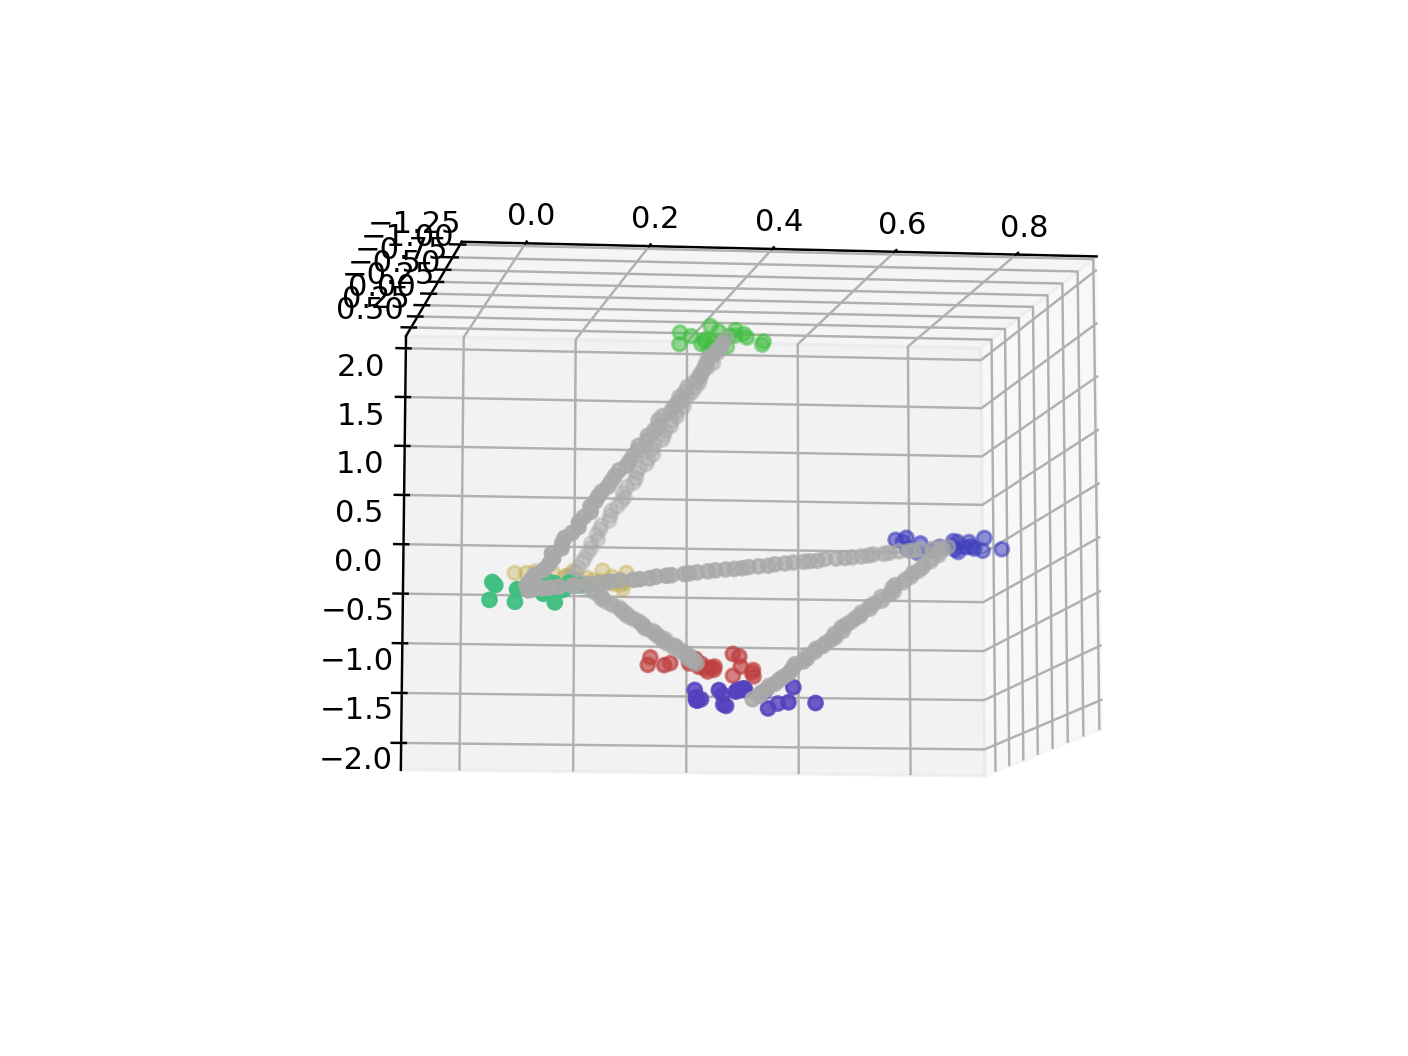

In [20]:
"""
name: "Linked Clusters",
description: "Clusters linked with a chain of points",
options: [
  {
    name: "Number of clusters",
    min: 3,
    max: 20,
    start: 6
  },
  {
    name: "Points per cluster",
    min: 10,
    max: 100,
    start: 30
  },
  {
    name: "Points per link",
    min: 5,
    max: 100,
    start: 15
  },
  {
    name: "Dimensions",
    min: 3,
    max: 100,
    start: 10
  }
],
generator: generators.linkedClusters

name: "Linked Clusters",
options: [
  { name: "Number of clusters", start: 6 },
  { name: "Points per cluster", start: 100 },
  { name: "Points per link", start: 50 },
  { name: "Dimensions", start: 10 }
"""
points = linkedClusters(6, 20, 50, 3)
data = np.array(list(map(lambda point: point.coords, points)))
color = np.array(list(map(lambda point: point.color, points)))

fig = plt.figure()
ax = fig.add_subplot(111 , projection='3d')
ax.scatter3D(data[:, 0], data[:, 1], data[:, 2], color=color)
plt.show()

(200, 2)


<IPython.core.display.Javascript object>


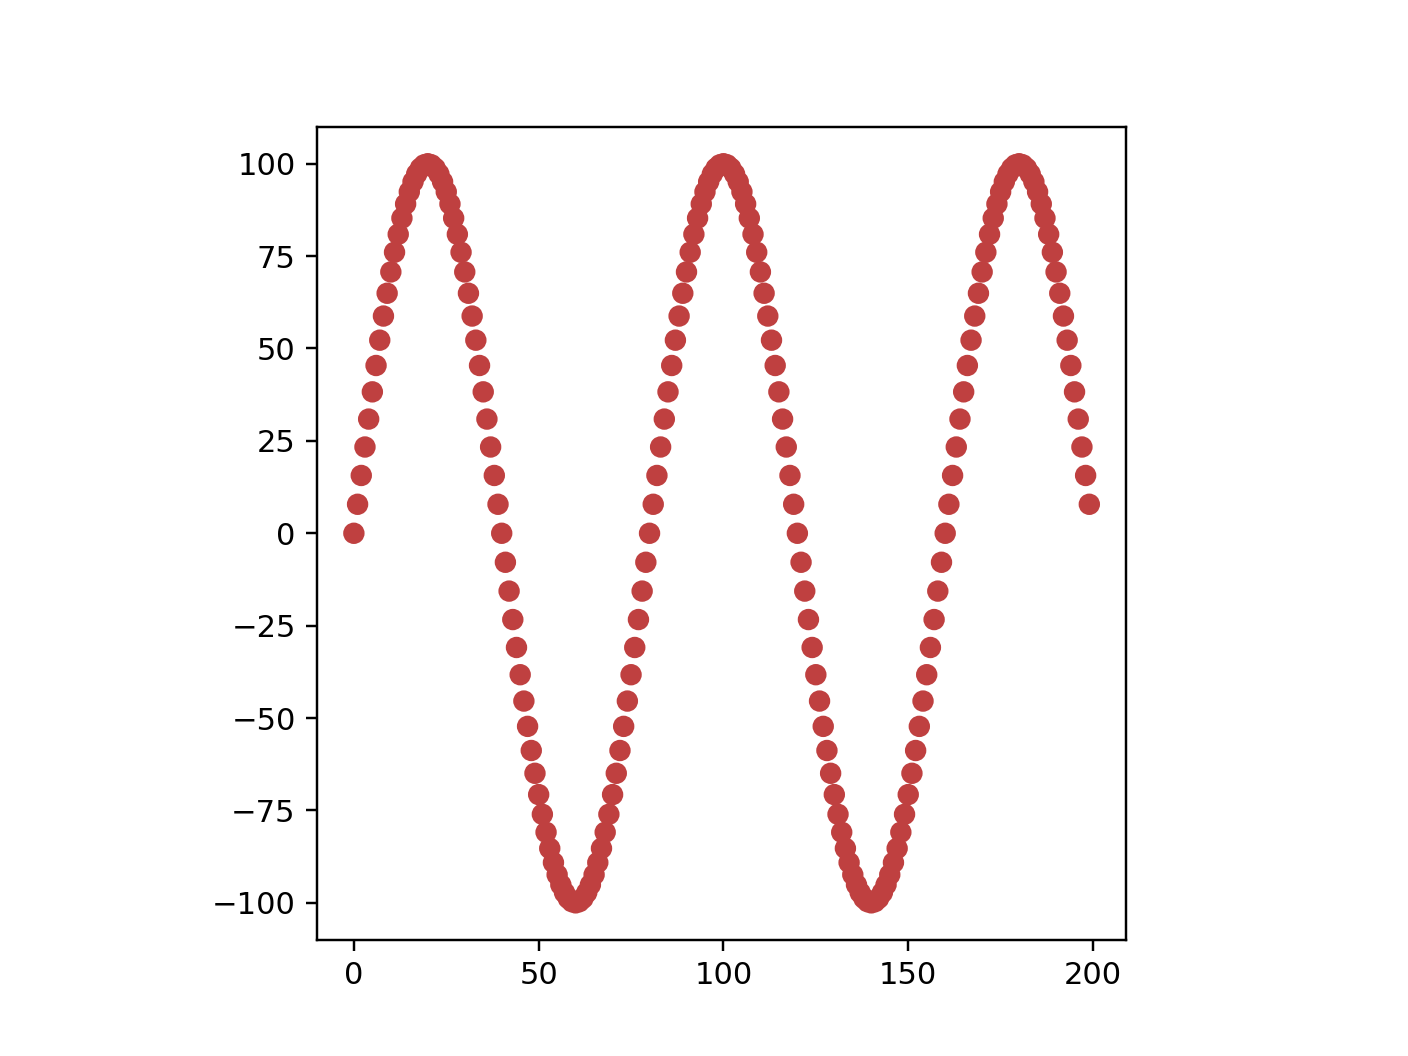

In [5]:
"""
name: "Sine frequency",
    description:
      "Vectors of a sine wave parameterized by frequency. Hue corresponds to frequency.",
    options: [
      {
        name: "Number of vectors",
        min: 10,
        max: 200,
        start: 50
      },
      {
        name: "Vector size",
        min: 3,
        max: 300,
        start: 100
      }
    ],
    generator: generators.sineFrequency,
    previewOverride: generators.sineFreqPreview

name: "Sine frequency",
    options: [
      { name: "Number of vectors", start: 200 },
      { name: "Vector size", start: 256 }
"""

points = sineFreqPreview(200)
data = np.array(list(map(lambda point: point.coords, points)))
color = np.array(list(map(lambda point: point.color, points)))
print(data.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data[:, 0], data[:, 1], color=color)
ax.set_aspect('equal')
plt.show()

(200, 2)


<IPython.core.display.Javascript object>


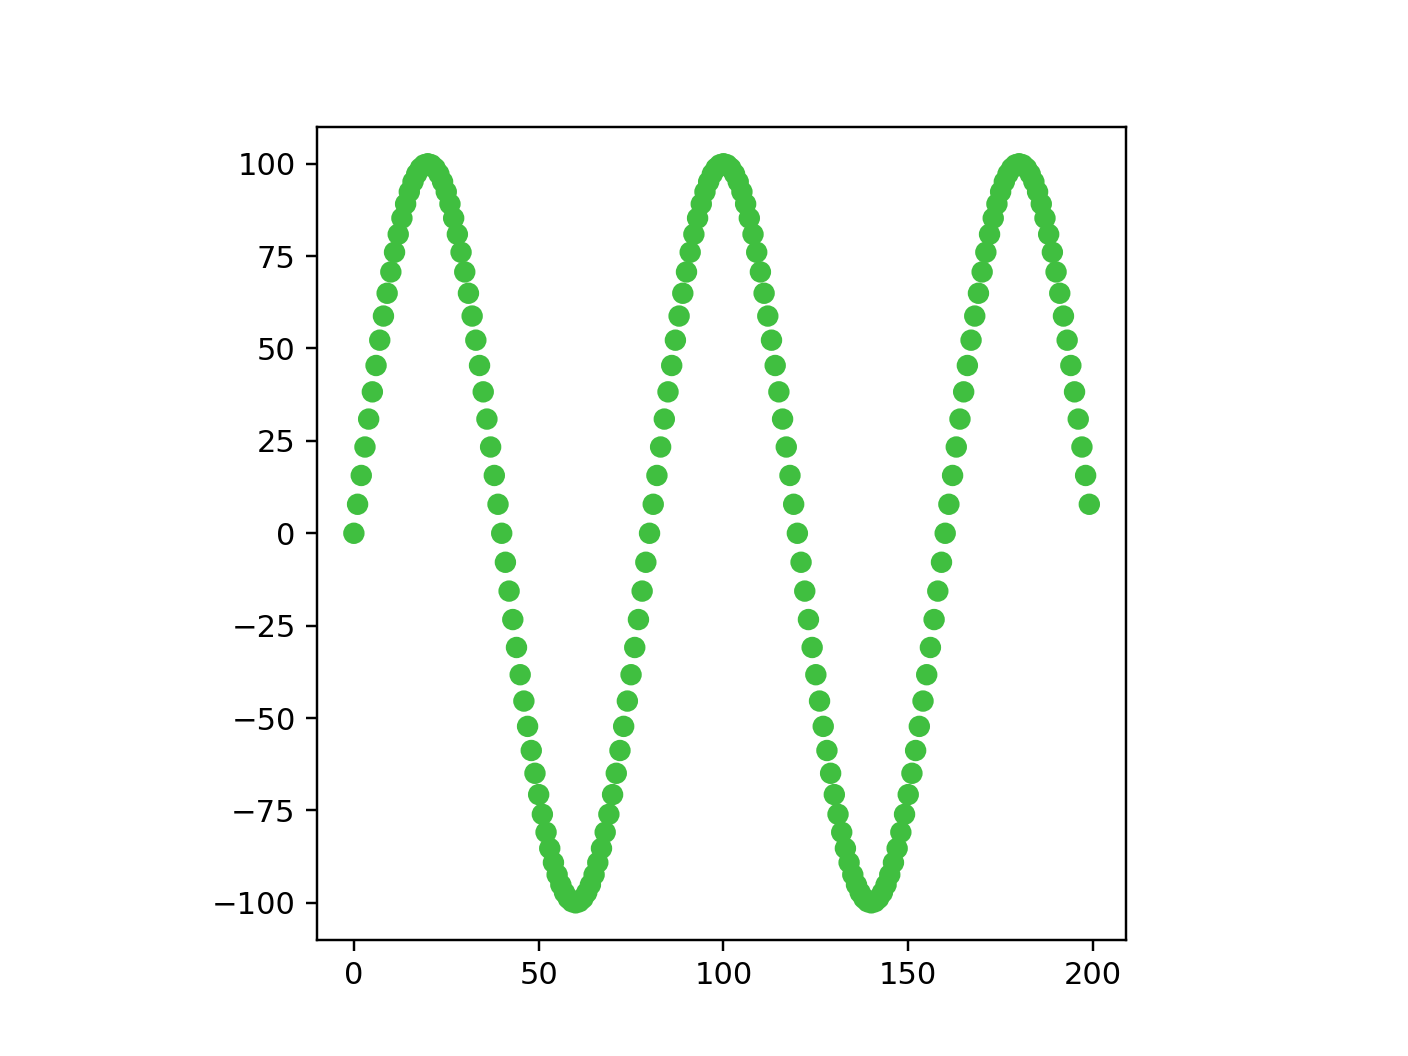

In [63]:
"""
name: "Sine phase",
    description:
      "Vectors of a sine wave parameterized by phase. Hue corresponds to phase.",
    options: [
      {
        name: "Number of vectors",
        min: 10,
        max: 200,
        start: 50
      },
      {
        name: "Vector size",
        min: 3,
        max: 300,
        start: 100
      }
    ],
    generator: generators.sinePhase,
    previewOverride: generators.sinePhasePreview
    
name: "Sine phase",
    options: [
      { name: "Number of vectors", start: 200 },
      { name: "Vector size", start: 256 }
"""

points = sinePhasePreview(200)
data = np.array(list(map(lambda point: point.coords, points)))
color = np.array(list(map(lambda point: point.color, points)))
print(data.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data[:, 0], data[:, 1], color=color)
ax.set_aspect('equal')
plt.show()

<IPython.core.display.Javascript object>


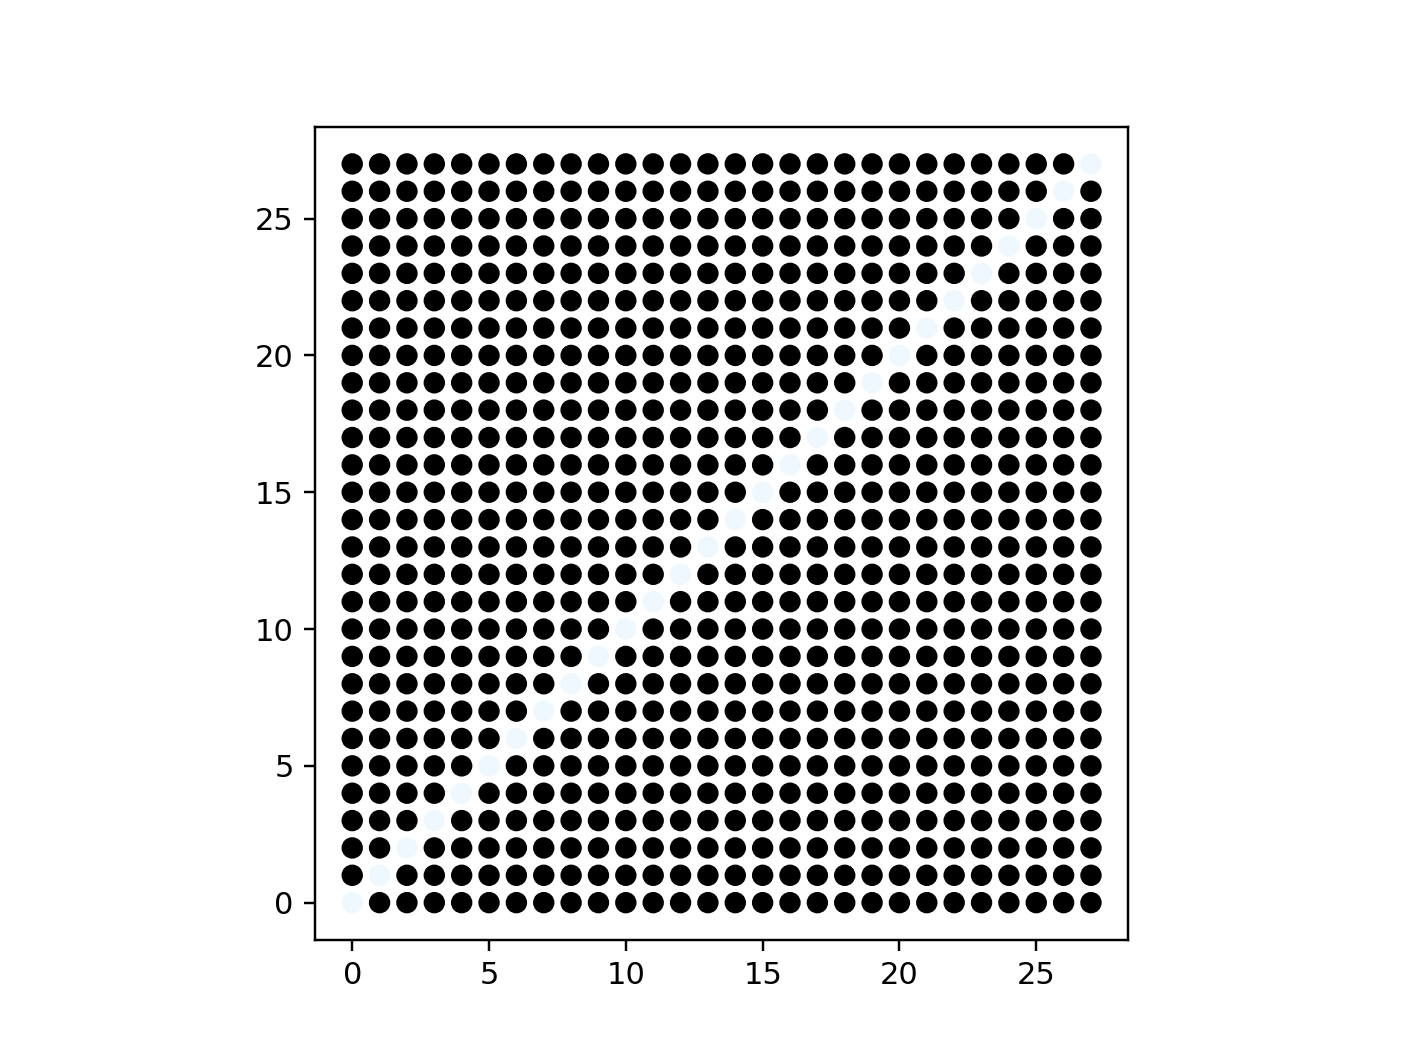

In [6]:
"""
name: "Rotated lines",
    description:
      "nxn images of a line rotated smoothly around the center, represented as an n*n dimensional vector.",
    options: [
      {
        name: "Number of lines",
        min: 10,
        max: 200,
        start: 50
      },
      {
        name: "Pixels per side",
        min: 5,
        max: 28,
        start: 10
      }
    ],
    generator: generators.continuousLineImages,
    previewOverride: generators.linePreview
    
    name: "Rotated lines",
    options: [
      { name: "Number of lines", start: 200 },
      { name: "Pixels per side", start: 28 }
"""

points = linePreview(200, 28)
data = np.array(list(map(lambda point: point.coords, points)))
color = np.array(list(map(lambda point: point.color, points)))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data[:, 0], data[:, 1], color=color)
ax.set_aspect('equal')
plt.show()

<IPython.core.display.Javascript object>


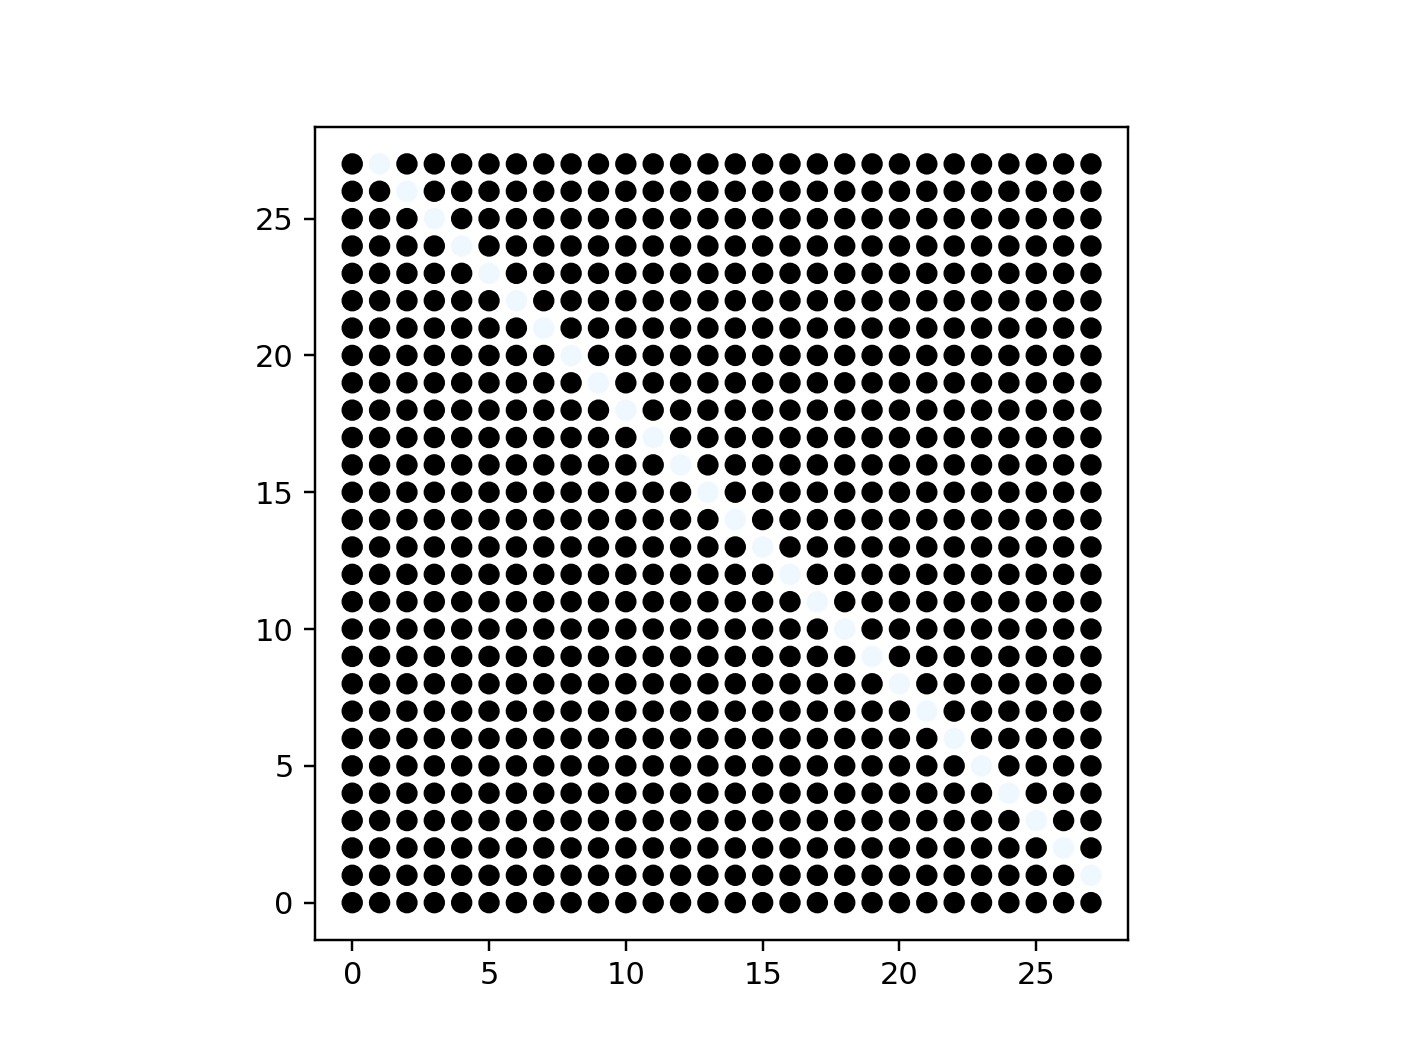

In [19]:
"""
name: "Rotated lines, clustered",
    description:
      "nxn images of a line rotated around the center, represented as an n*n dimensional vector. Grouped by similar angles.",
    options: [
      {
        name: "Number of lines",
        min: 10,
        max: 200,
        start: 50
      },
      {
        name: "Number of clusters",
        min: 3,
        max: 12,
        start: 5
      },
      {
        name: "Noise",
        min: 0,
        max: 100,
        start: 8
      },
      {
        name: "Pixels per side",
        min: 5,
        max: 28,
        start: 10
      }
    ],
    generator: generators.clusteredLineImages,
    previewOverride: generators.lineClusterPreview
    
    name: "Rotated lines, clustered",
    options: [
      { name: "Number of lines", start: 200 },
      { name: "Number of clusters", start: 10 },
      { name: "Noise", start: 8 },
      { name: "Pixels per side", start: 28 }
"""
points = lineClusterPreview(200, 28)
data = np.array(list(map(lambda point: point.coords, points)))
color = np.array(list(map(lambda point: point.color, points)))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data[:, 0], data[:, 1], color=color)
ax.set_aspect('equal')
plt.show()

<IPython.core.display.Javascript object>


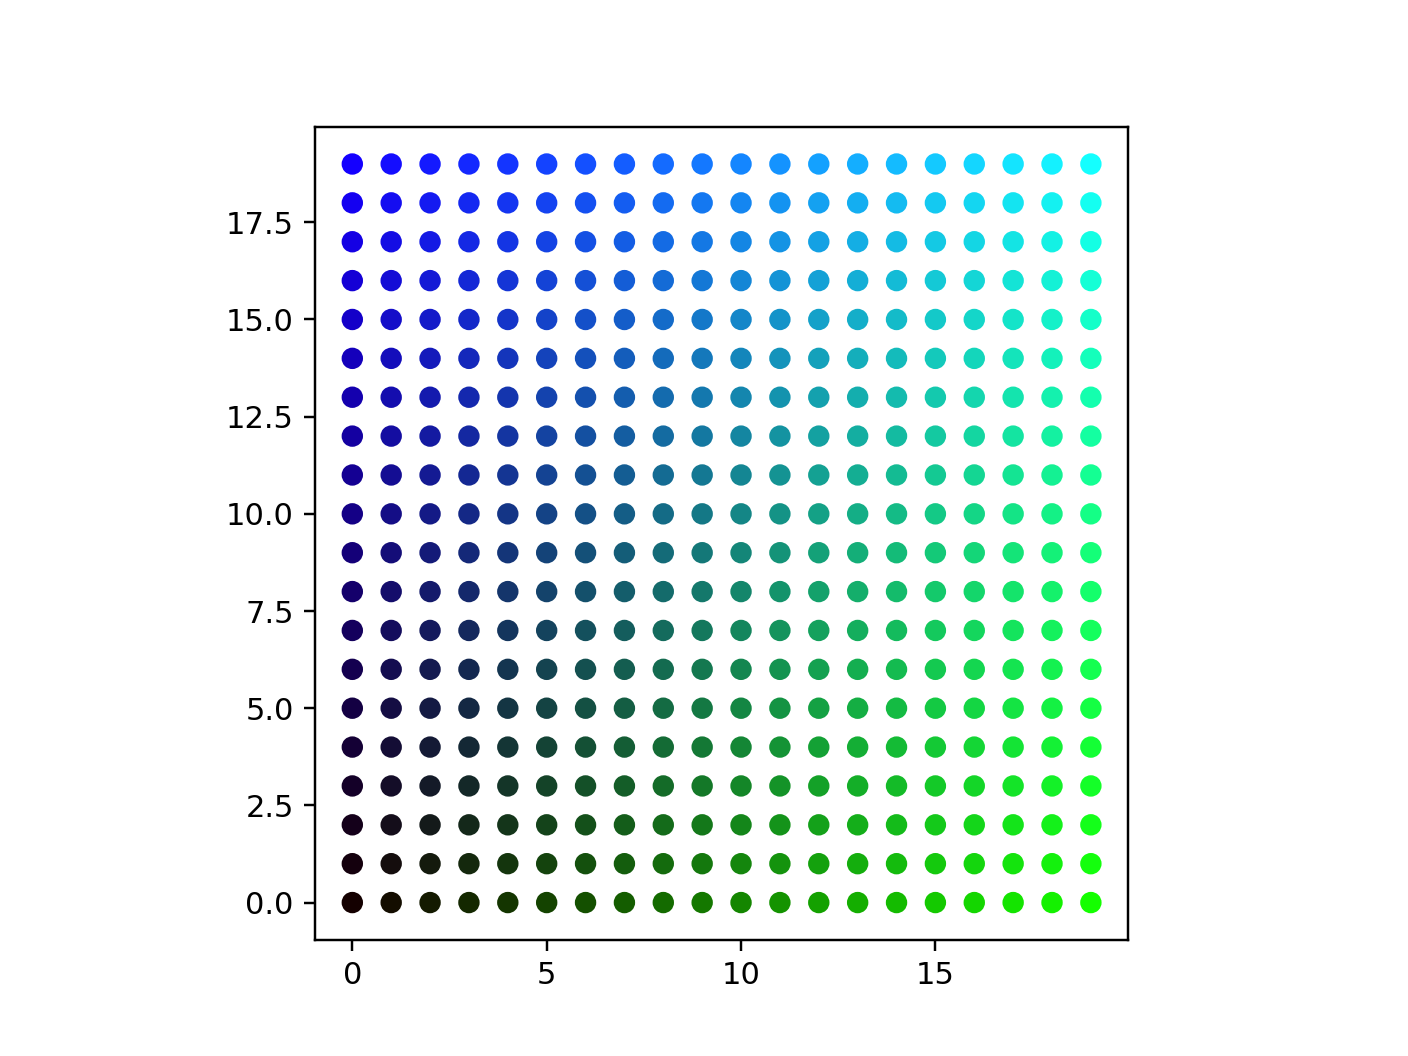

In [102]:
# name: "Grid",
# options: [{ name: "Points Per Side", start: 20 }],
# description: "A square grid with equal spacing between points."
points = gridData(20)
data = np.array(list(map(lambda point: point.coords, points)))
color = np.array(list(map(lambda point: point.color, points))) / 255.0

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data[:, 0], data[:, 1], color=color)
ax.set_aspect('equal')
plt.show()

(200, 2)


<IPython.core.display.Javascript object>


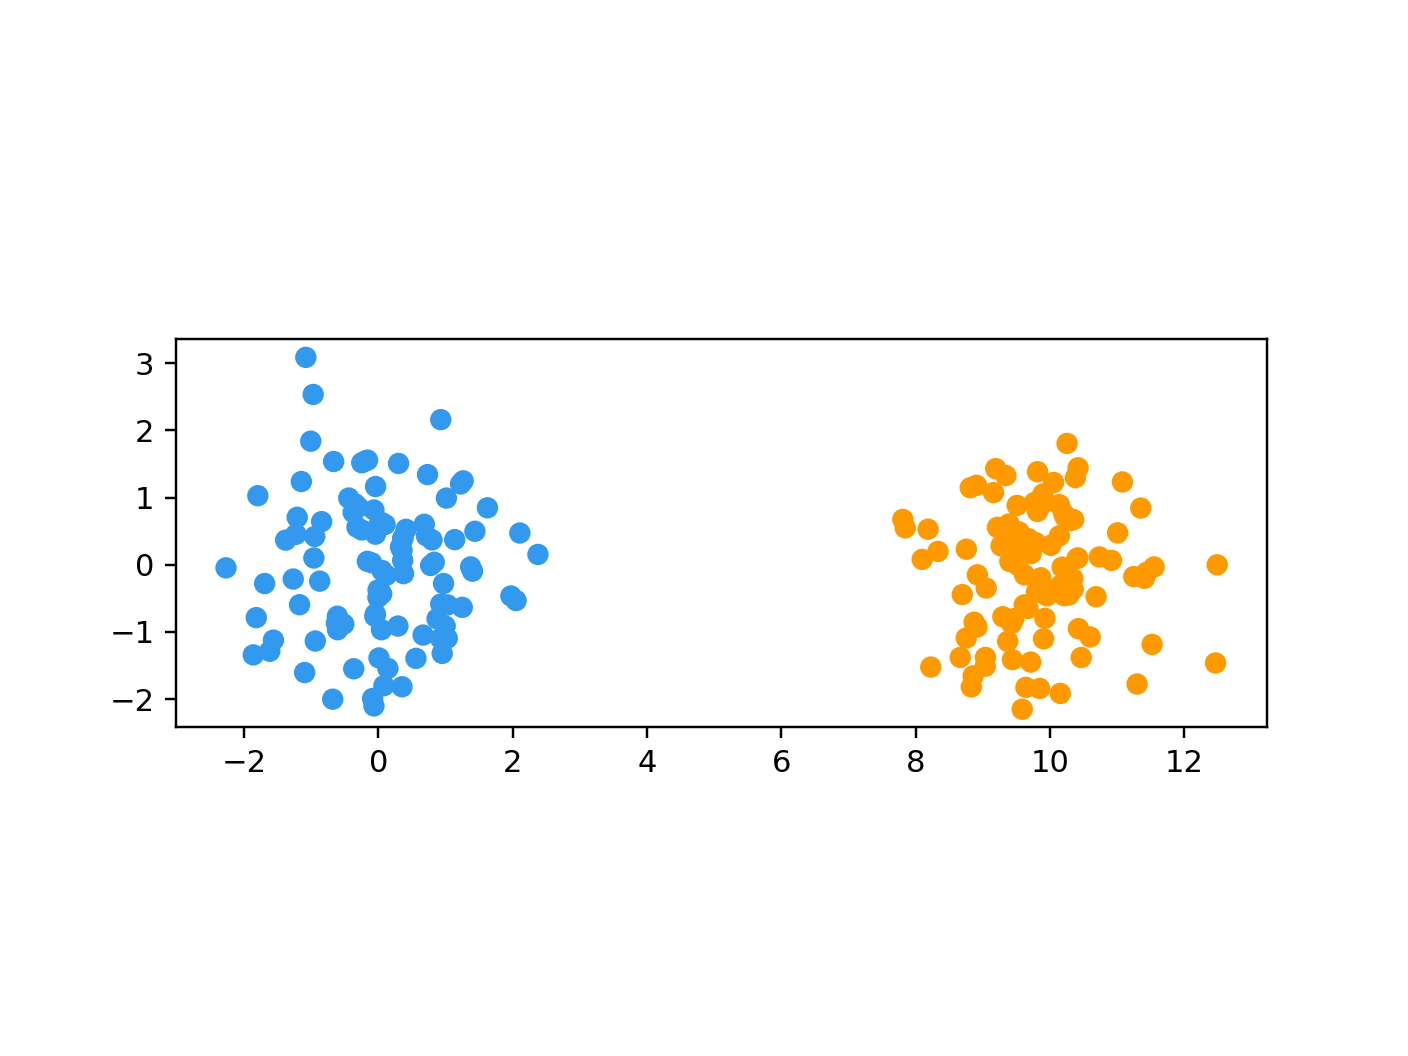

In [8]:
# name: "Two Clusters",
#     description: "Two clusters with equal numbers of points.",
#     options: [
#       {
#         name: "Points Per Cluster",
#         min: 10,
#         max: 100,
#         start: 50
#       },
#       {
#         name: "Dimensions",
#         min: 1,
#         max: 100,
#         start: 2
#       }
#     ],
#     generator: generators.twoClustersData
# name: "Two Clusters",
#     options: [
#       { name: "Points Per Cluster", start: 100 },
#       { name: "Dimensions", start: 50 }
points = twoClustersData(100, 2)
data = np.array(list(map(lambda point: point.coords, points)))
color = np.array(list(map(lambda point: point.color, points)))
print(data.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data[:, 0], data[:, 1], color=color)
ax.set_aspect('equal')
plt.show()

(300, 2)


<IPython.core.display.Javascript object>


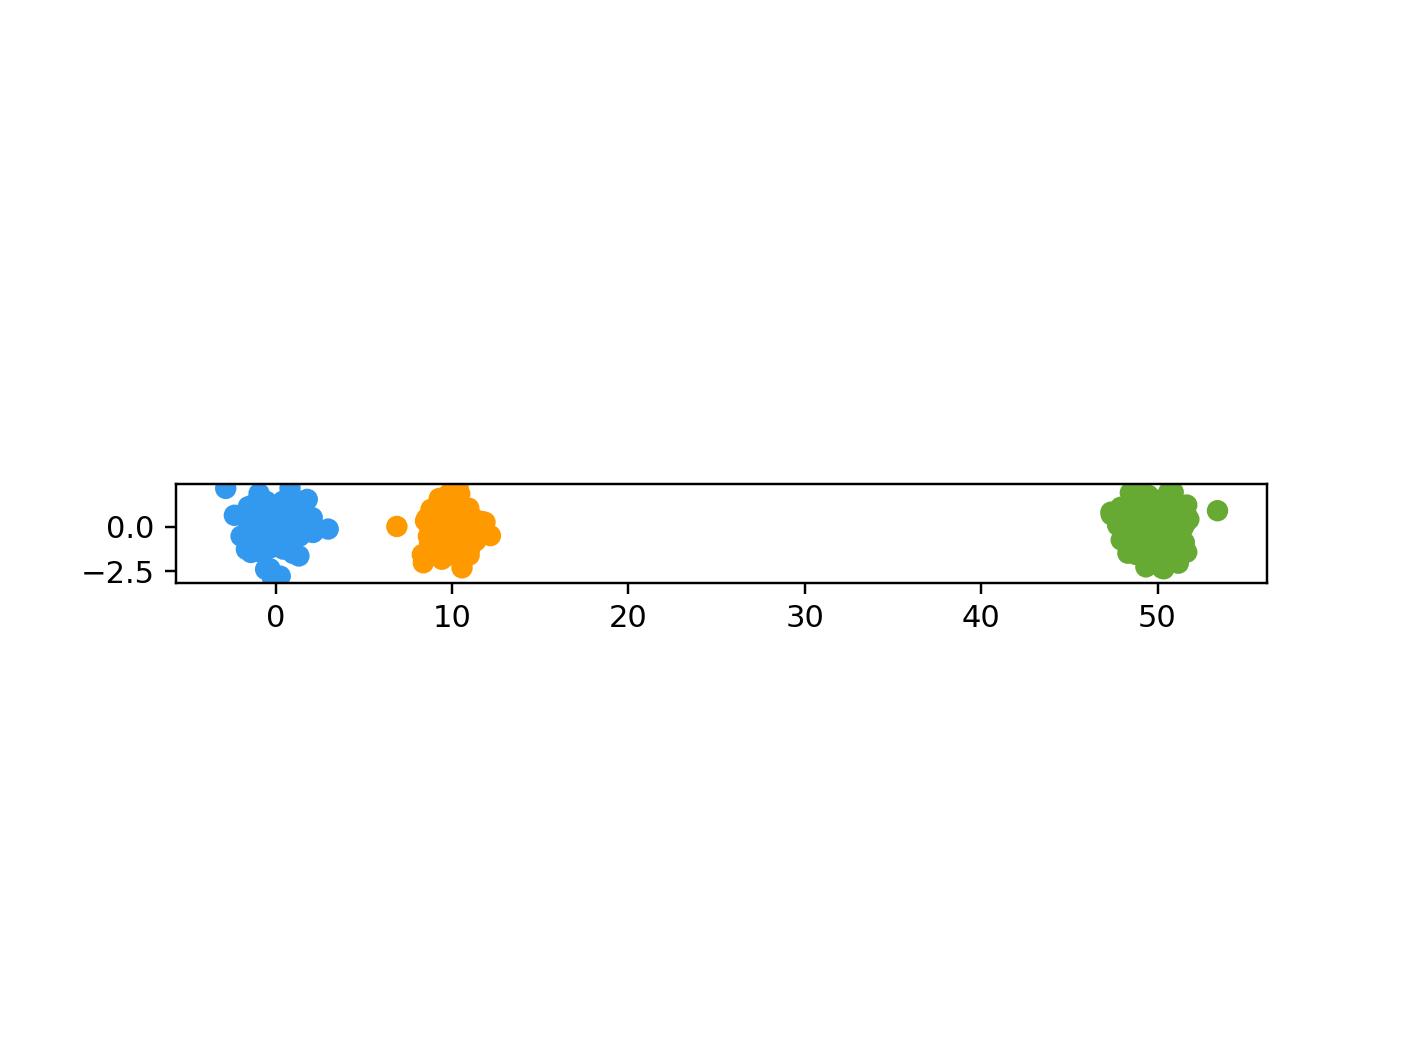

In [9]:
# threeClustersData2d
points = threeClustersData2d(100)
data = np.array(list(map(lambda point: point.coords, points)))
color = np.array(list(map(lambda point: point.color, points)))
print(data.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data[:, 0], data[:, 1], color=color)
ax.set_aspect('equal')
plt.show()

(200, 2)


/Users/tsuno/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


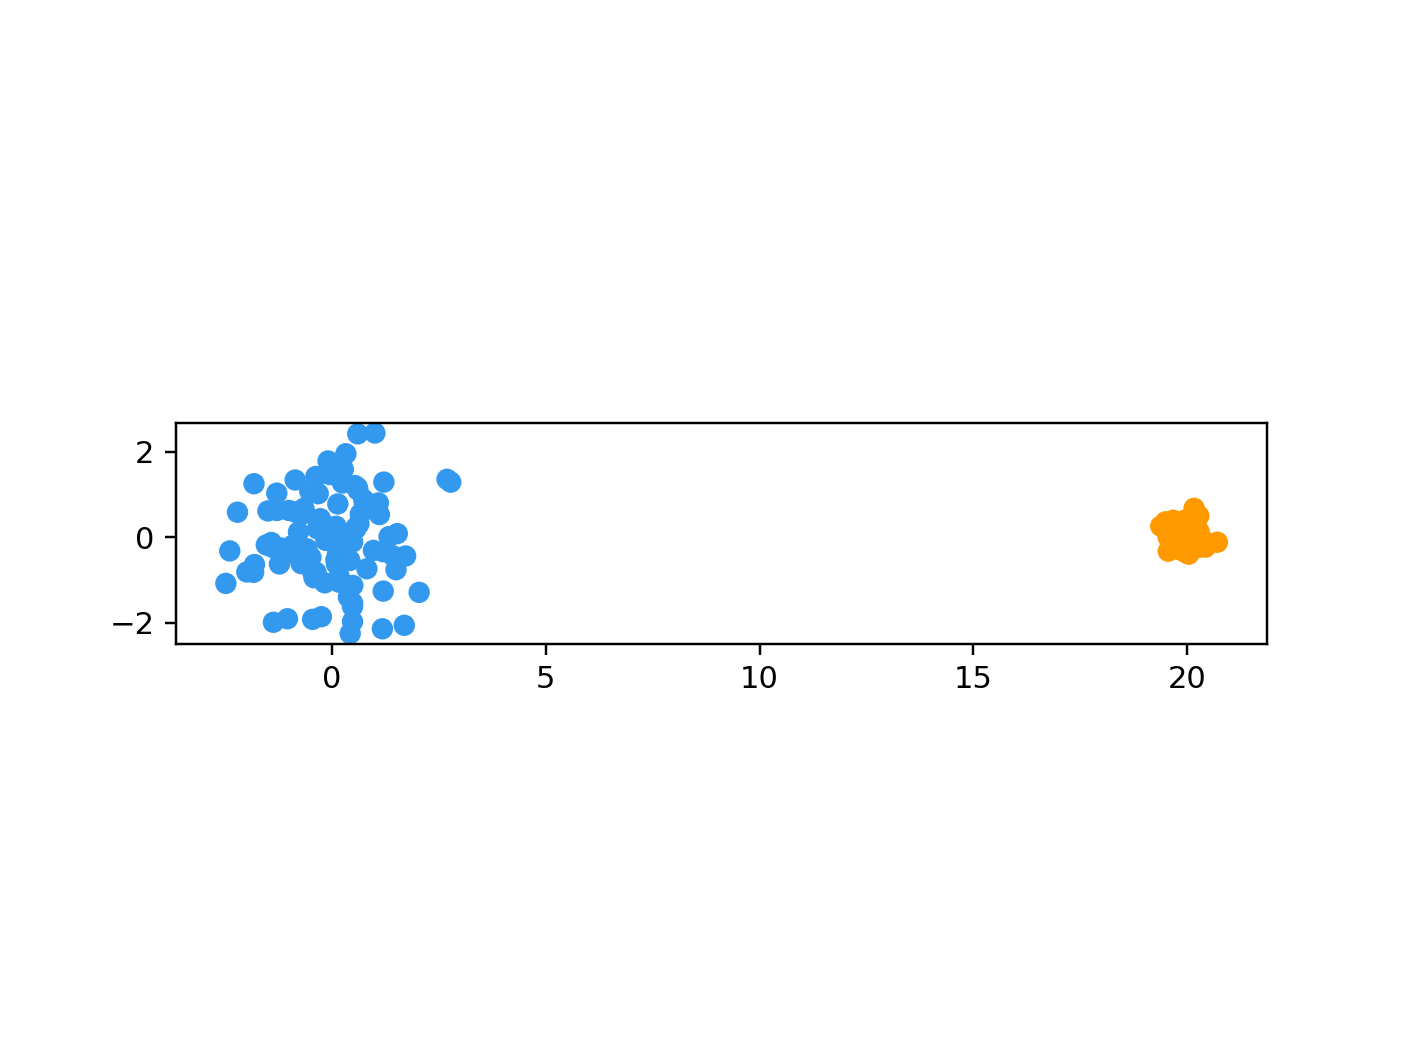

In [104]:
# twoDifferentClustersData
"""
name: "Two Different-Sized Clusters",
    description:
      "Two clusters with equal numbers of points, but different " +
      "variances within the clusters.",
    options: [
      {
        name: "Points Per Cluster",
        min: 10,
        max: 100,
        start: 50
      },
      {
        name: "Dimensions",
        min: 1,
        max: 100,
        start: 2
      },
      {
        name: "Scale",
        min: 1,
        max: 10,
        start: 5
      }
    ],
    generator: generators.twoDifferentClustersData

name: "Two Different-Sized Clusters",
    options: [
      { name: "Points Per Cluster", start: 100 },
      { name: "Dimensions", start: 50 },
      { name: "Scale", start: 5 }
"""
points = twoDifferentClustersData(100, 2, 5)
data = np.array(list(map(lambda point: point.coords, points)))
color = np.array(list(map(lambda point: point.color, points)))
print(data.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data[:, 0], data[:, 1], color=color)
ax.set_aspect('equal')
plt.show()

(200, 2)


<IPython.core.display.Javascript object>


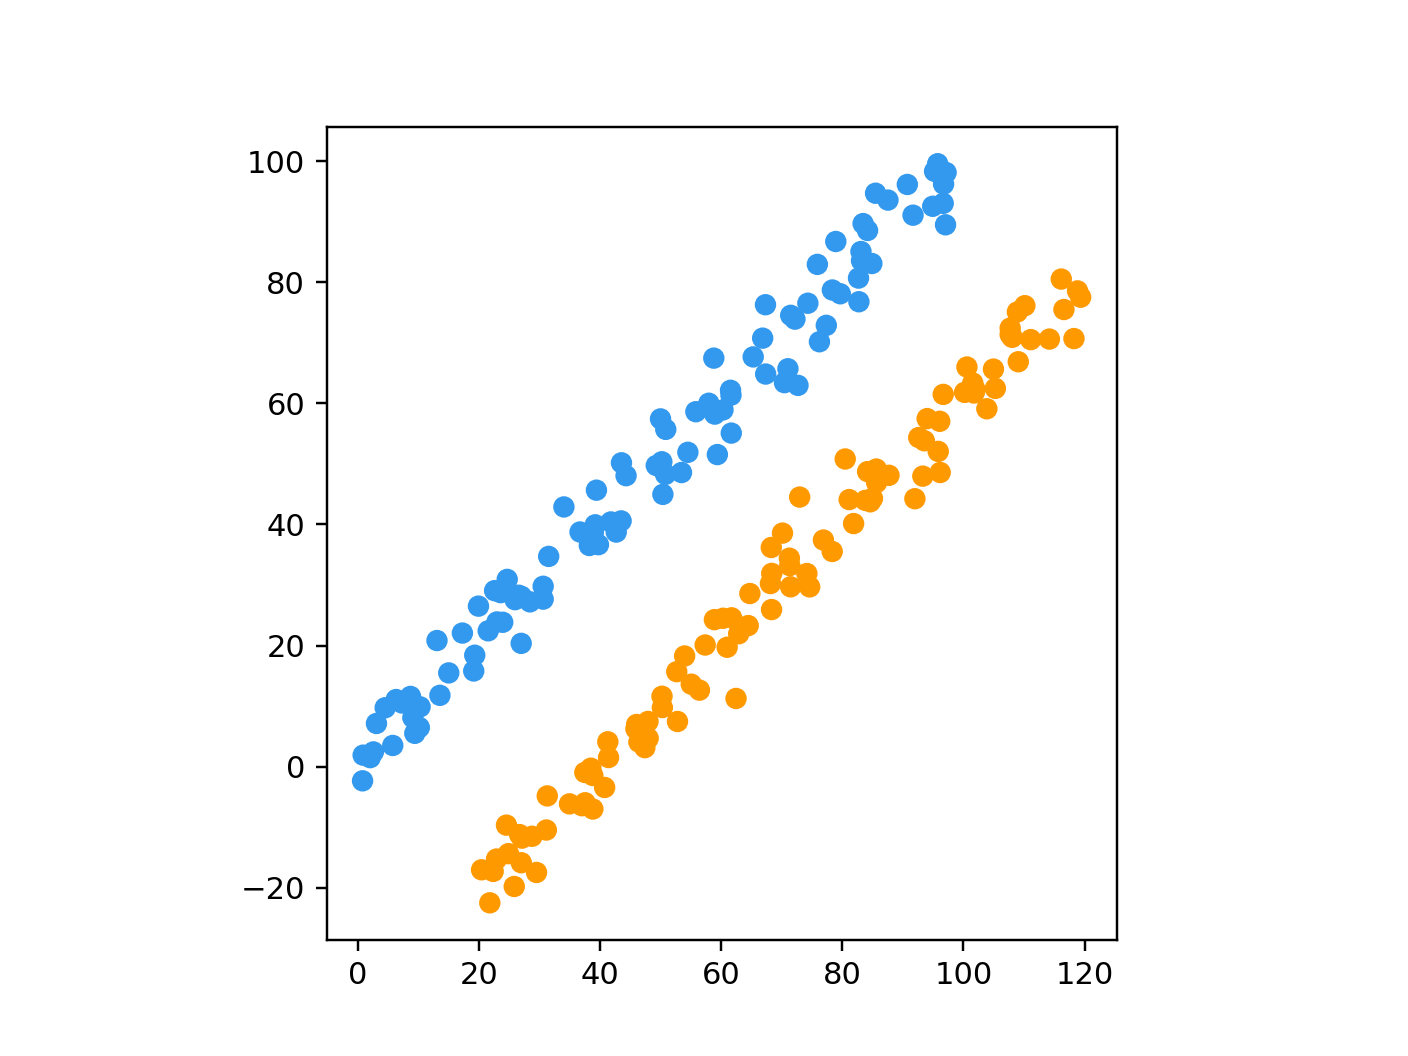

In [10]:
# longClusterData
"""
name: "Two Long Linear Clusters",
    description:
      "Two sets of points, arranged in parallel lines that " +
      "are close to each other. Note curvature of lines.",
    options: [
      {
        name: "Points Per Cluster",
        min: 10,
        max: 100,
        start: 50
      }
    ],
    generator: generators.longClusterData

name: "Two Long Linear Clusters",
    options: [{ name: "Points Per Cluster", start: 100 }]
"""

points = longClusterData(100)
data = np.array(list(map(lambda point: point.coords, points)))
color = np.array(list(map(lambda point: point.color, points)))
print(data.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data[:, 0], data[:, 1], color=color)
ax.set_aspect('equal')
plt.show()

(200, 2)


/Users/tsuno/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


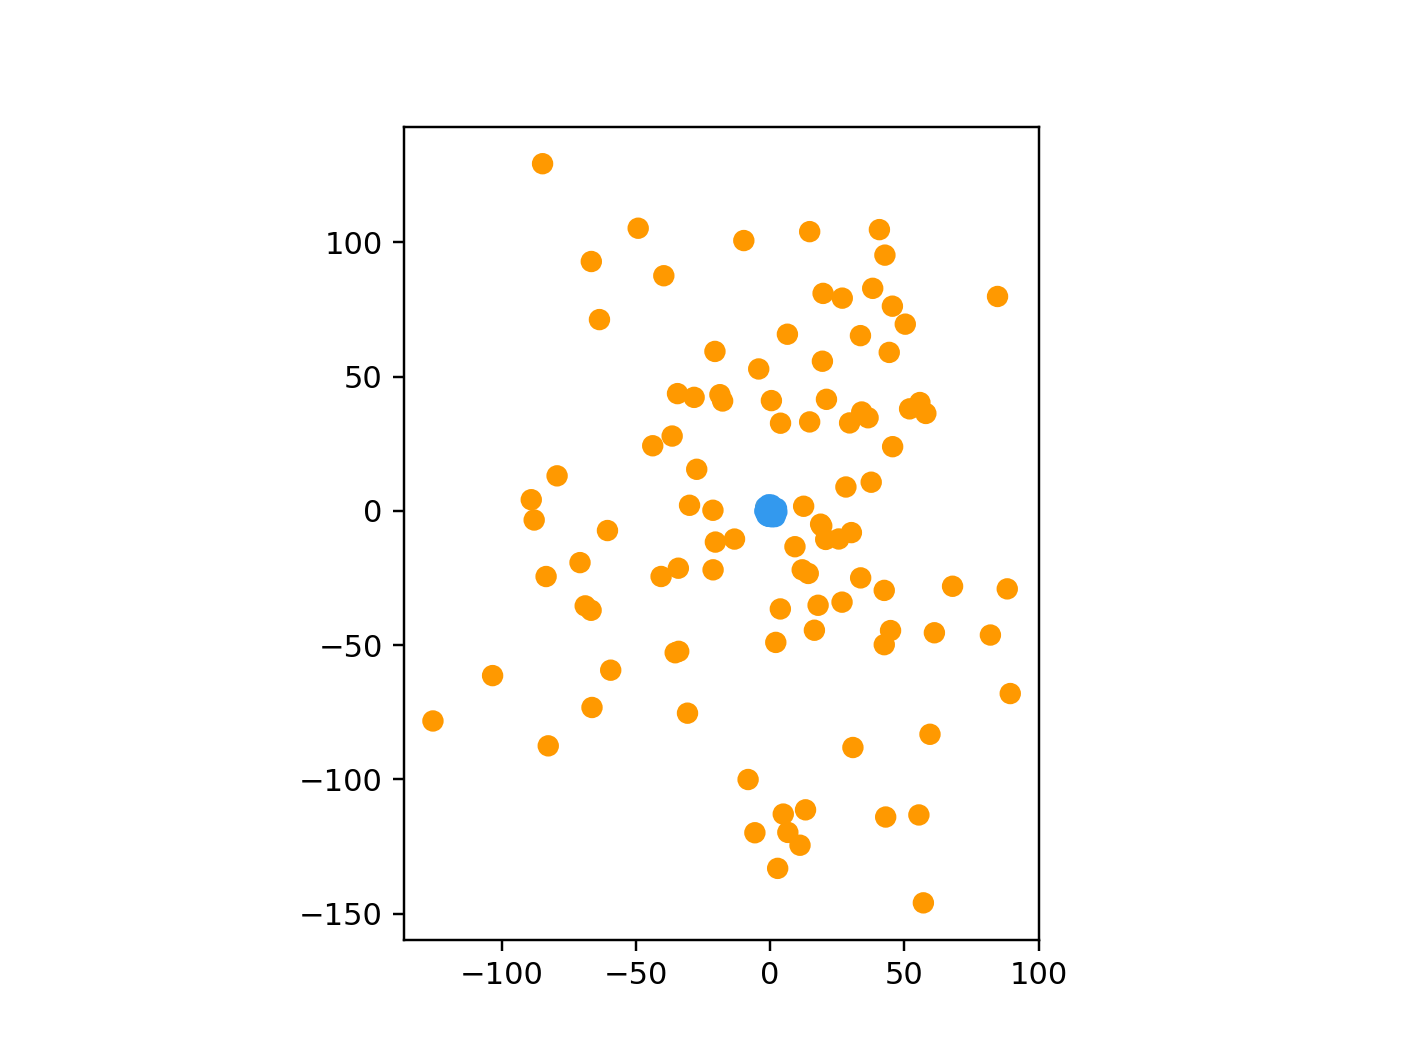

In [106]:
# subsetClustersData(色つけないとわからない)
# name: "Cluster In Cluster",
#     description: "A dense, tight cluster inside of a wide, sparse cluster.",
#     options: [
#       {
#         name: "Points Per Cluster",
#         min: 10,
#         max: 100,
#         start: 50
#       },
#       {
#         name: "Dimensions",
#         min: 1,
#         max: 100,
#         start: 2
#       }
#     ],
#     generator: generators.subsetClustersData
# name: "Cluster In Cluster",
#     options: [
#       { name: "Points Per Cluster", start: 100 },
#       { name: "Dimensions", start: 50 }
points = subsetClustersData(100, 2)
data = np.array(list(map(lambda point: point.coords, points)))
color = np.array(list(map(lambda point: point.color, points)))
print(data.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data[:, 0], data[:, 1], color=color)
ax.set_aspect('equal')
plt.show()

<IPython.core.display.Javascript object>


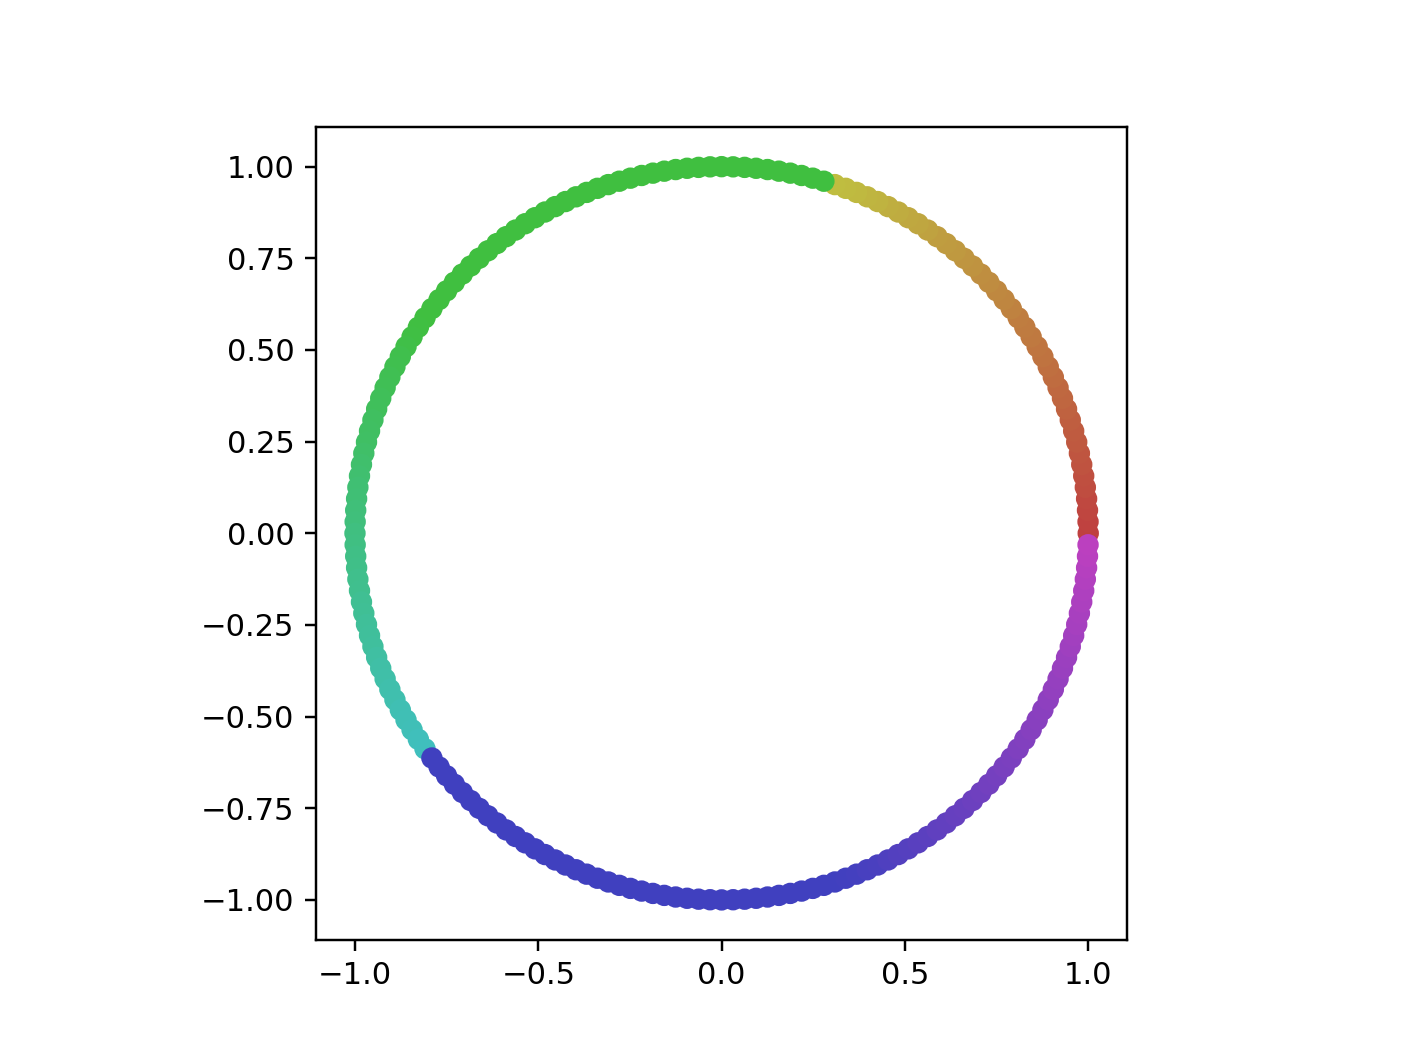

In [11]:
# name: "Circle (Evenly Spaced)",
# options: [{ name: "Number Of Points", start: 200 }]
points = circleData(200)
data = np.array(list(map(lambda point: point.coords, points)))
color = np.array(list(map(lambda point: point.color, points)))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data[:, 0], data[:, 1], color=color)
ax.set_aspect('equal')
plt.show()

<IPython.core.display.Javascript object>


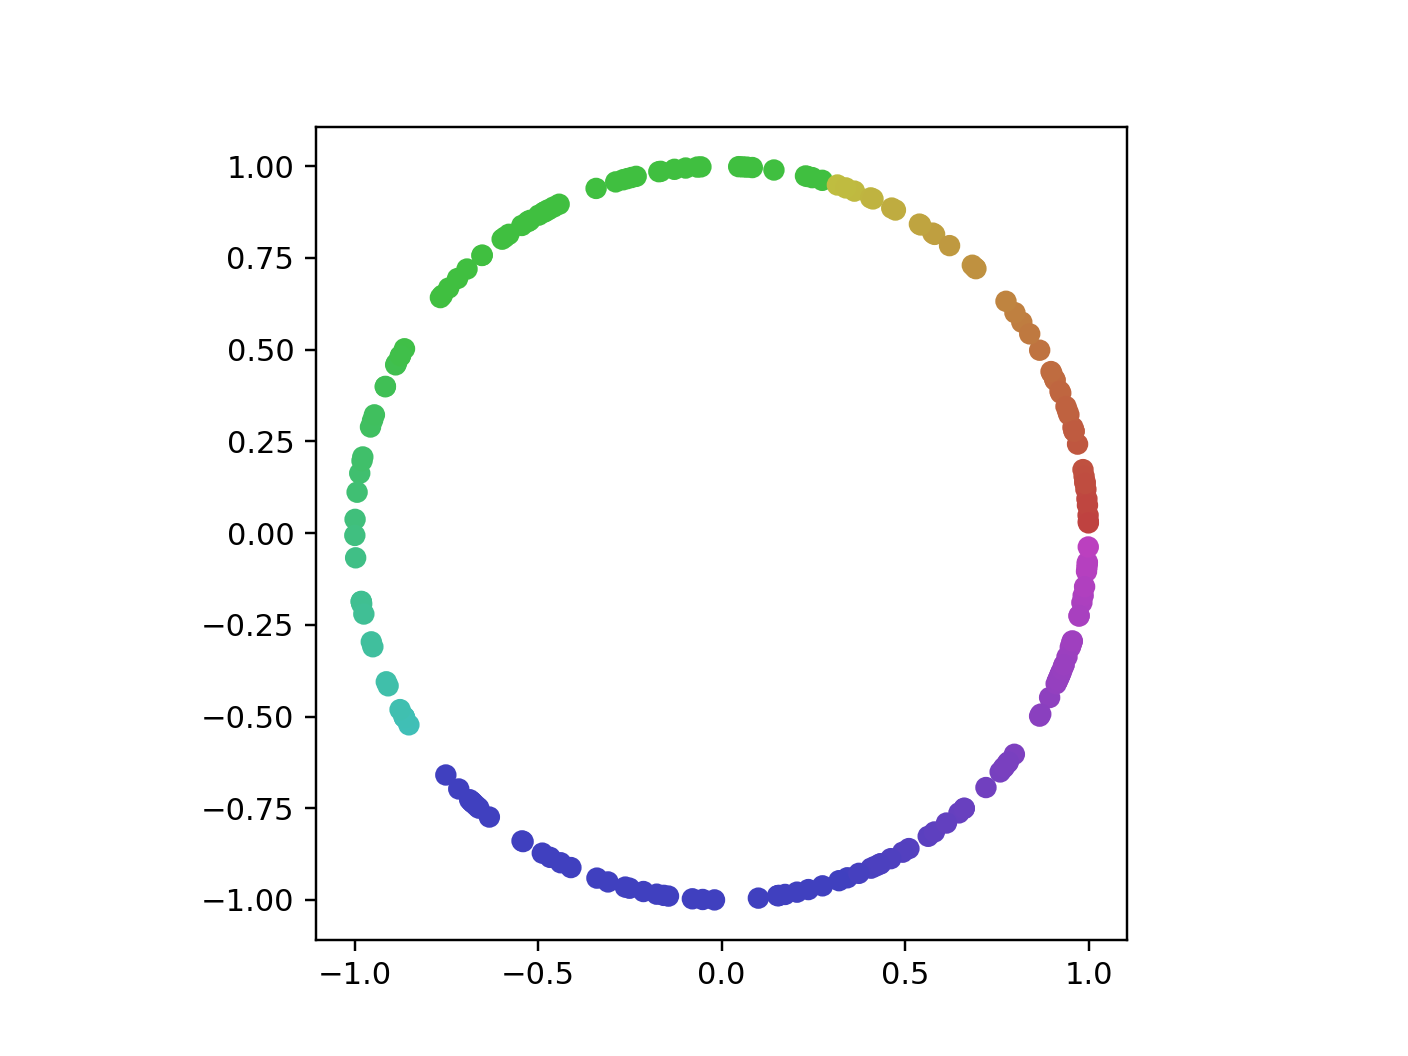

In [12]:
# name: "Circle (Randomly Spaced)",
# options: [{ name: "Number Of Points", start: 200 }]
points = randomCircleData(200)
data = np.array(list(map(lambda point: point.coords, points)))
color = np.array(list(map(lambda point: point.color, points)))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data[:, 0], data[:, 1], color=color)
ax.set_aspect('equal')
plt.show()

/Users/tsuno/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


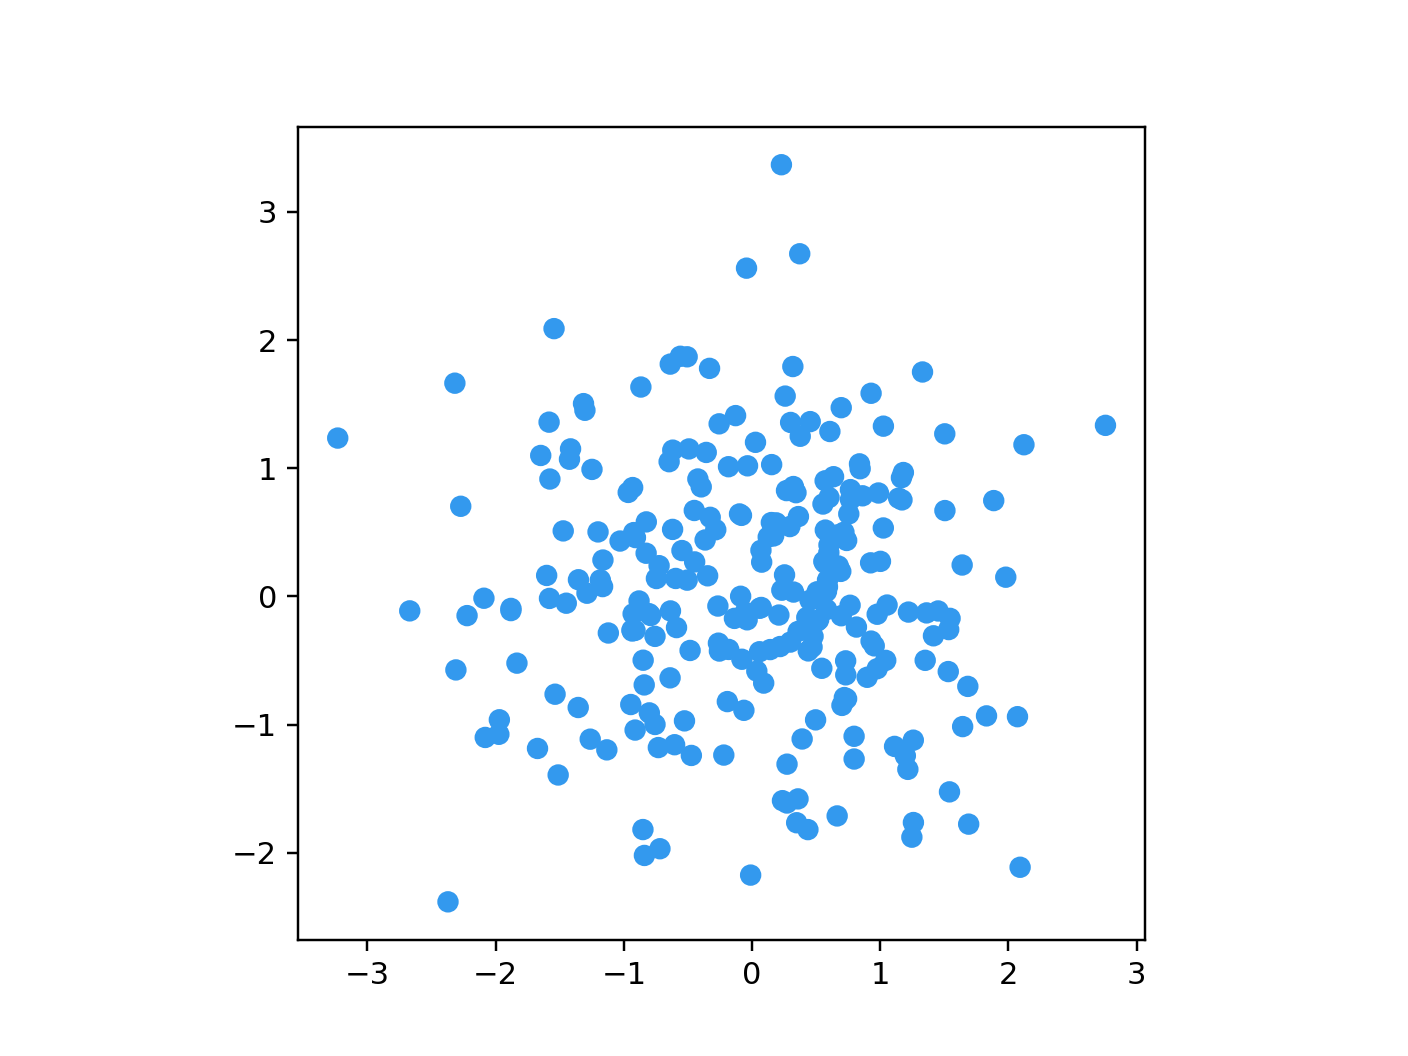

In [109]:
# name: "Gaussian Cloud",
# options: [
# { name: "Number Of Points", start: 250 },
# { name: "Dimensions", start: 50 }
points = gaussianData(250, 200)
data = np.array(list(map(lambda point: point.coords, points)))
color = np.array(list(map(lambda point: point.color, points)))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data[:, 0], data[:, 1], color=color)
ax.set_aspect('equal')
plt.show()

<IPython.core.display.Javascript object>


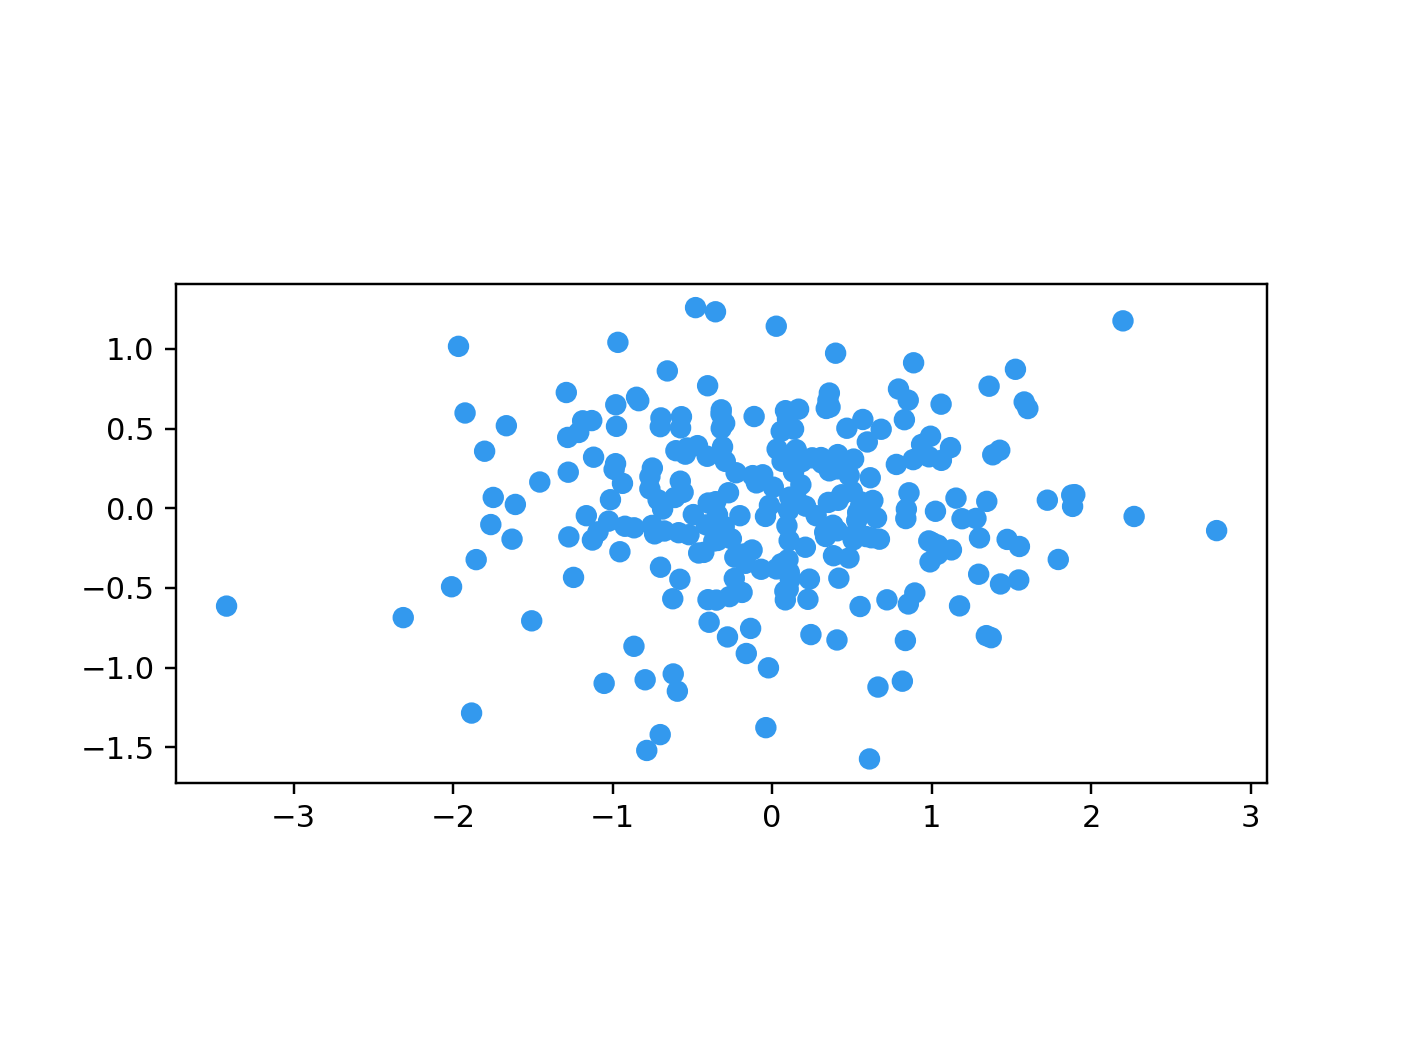

In [13]:
# name: "Ellipsoidal Gaussian Cloud",
# options: [
# { name: "Number Of Points", start: 250 },
# { name: "Dimensions", start: 50 }
points = longGaussianData(250, 50)
data = np.array(list(map(lambda point: point.coords, points)))
color = np.array(list(map(lambda point: point.color, points)))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data[:, 0], data[:, 1], color=color)
ax.set_aspect('equal')
plt.show()

/Users/tsuno/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


<IPython.core.display.Javascript object>


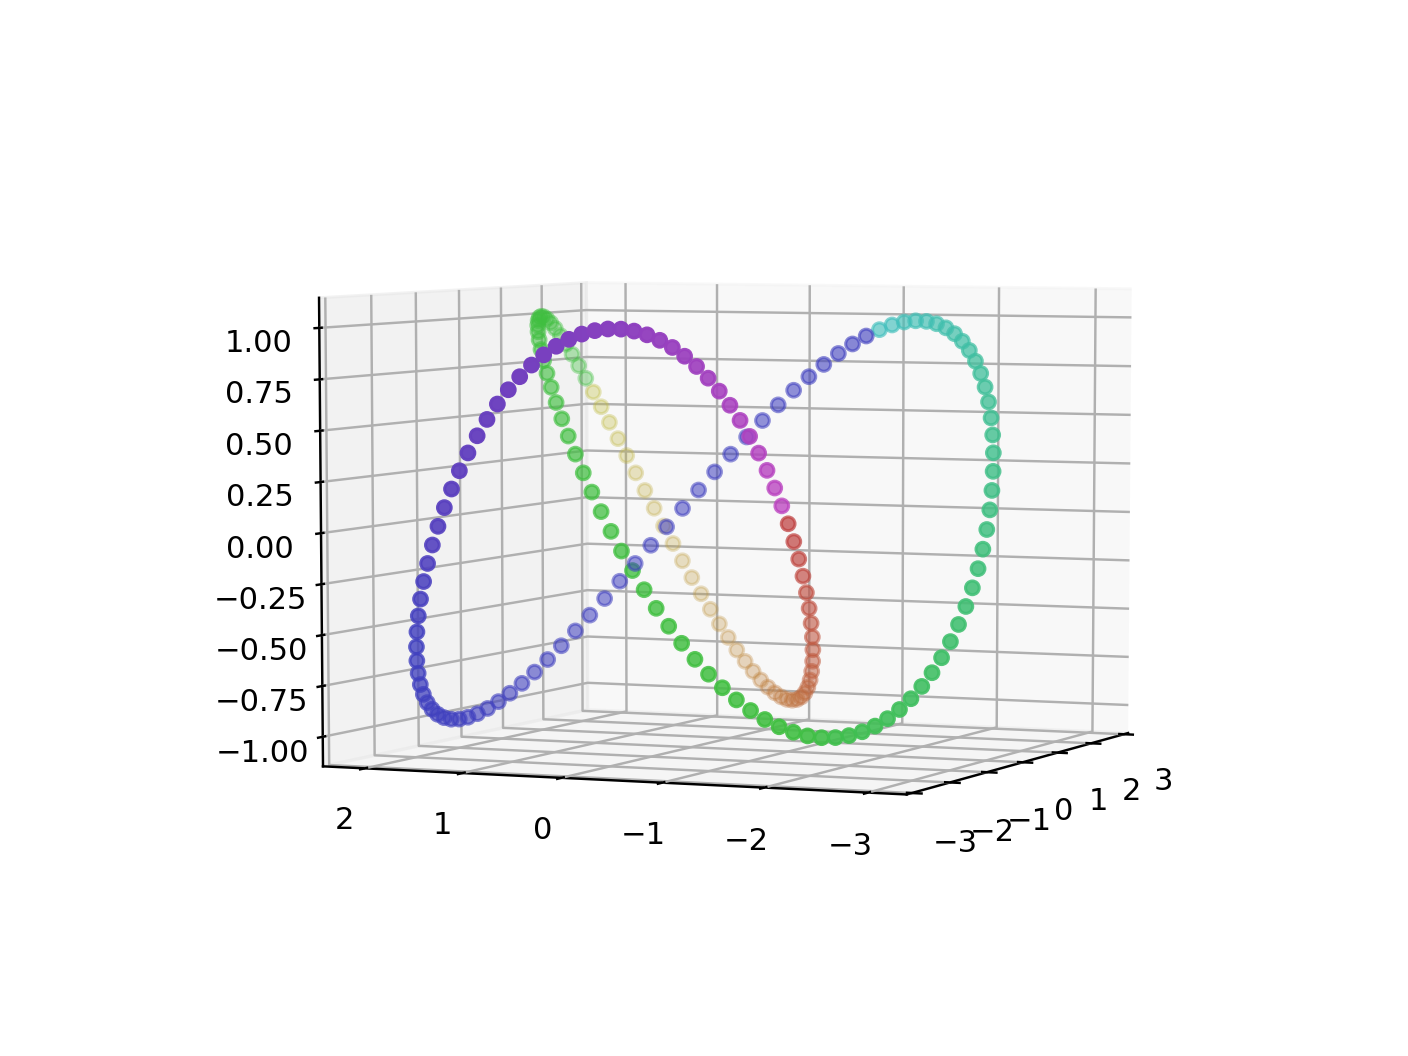

In [110]:
# trefoil knot(三葉結び目)
# default: 200
points = trefoilData(200)
data = np.array(list(map(lambda point: point.coords, points)))
color = np.array(list(map(lambda point: point.color, points)))

fig = plt.figure()
ax = fig.add_subplot(111 , projection='3d')
ax.scatter3D(data[:, 0], data[:, 1], data[:, 2], color=color)
plt.show()

<IPython.core.display.Javascript object>


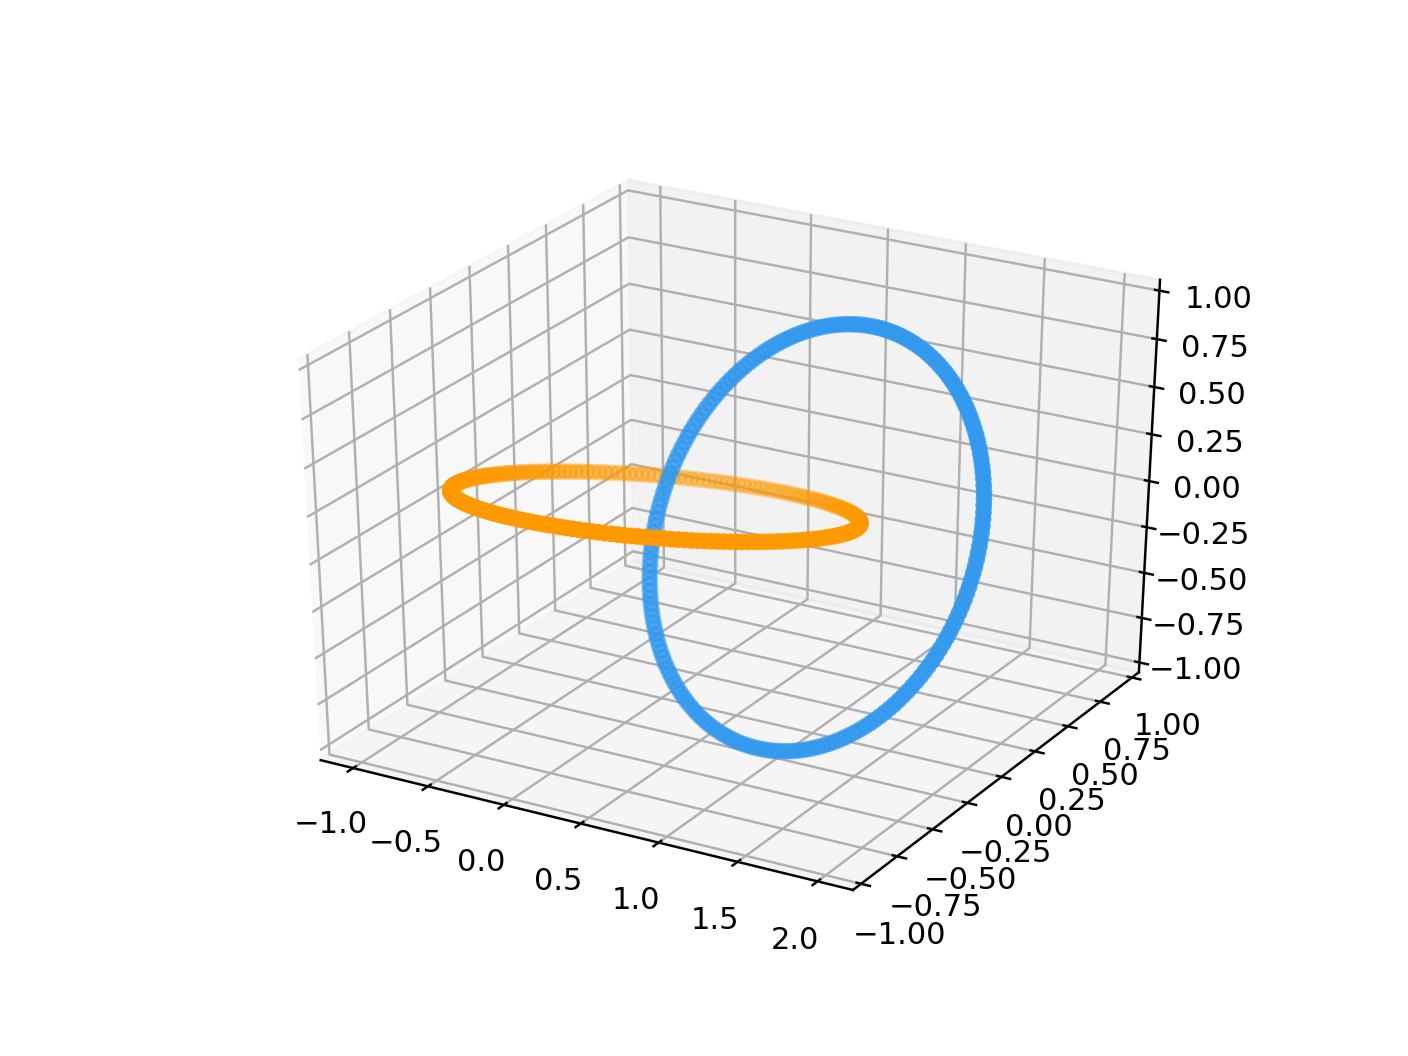

In [14]:
# Linked Rings
# default: 200
points = linkData(200)
data = np.array(list(map(lambda point: point.coords, points)))
color = np.array(list(map(lambda point: point.color, points)))

fig = plt.figure()
ax = fig.add_subplot(111 , projection='3d')
ax.scatter3D(data[:, 0], data[:, 1], data[:, 2], color=color)
plt.show()

<IPython.core.display.Javascript object>


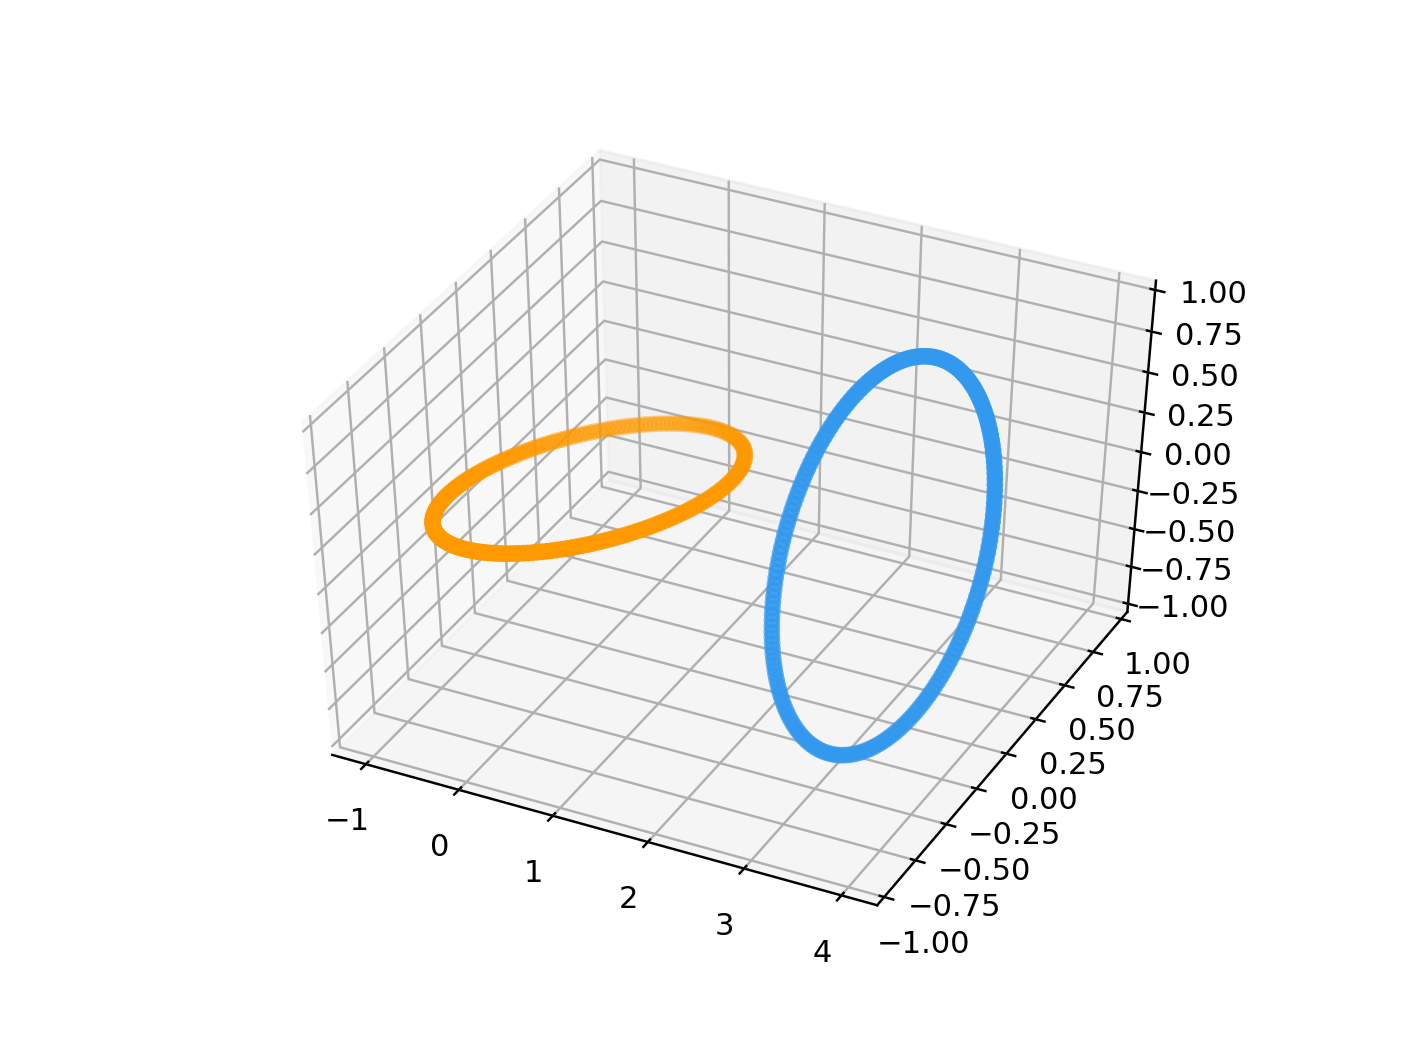

In [12]:
# unLinked Rings
points = unlinkData(200)
data = np.array(list(map(lambda point: point.coords, points)))
color = np.array(list(map(lambda point: point.color, points)))

fig = plt.figure()
ax = fig.add_subplot(111 , projection='3d')
ax.scatter3D(data[:, 0], data[:, 1], data[:, 2], color=color)
plt.show()

(200, 200)


/Users/tsuno/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


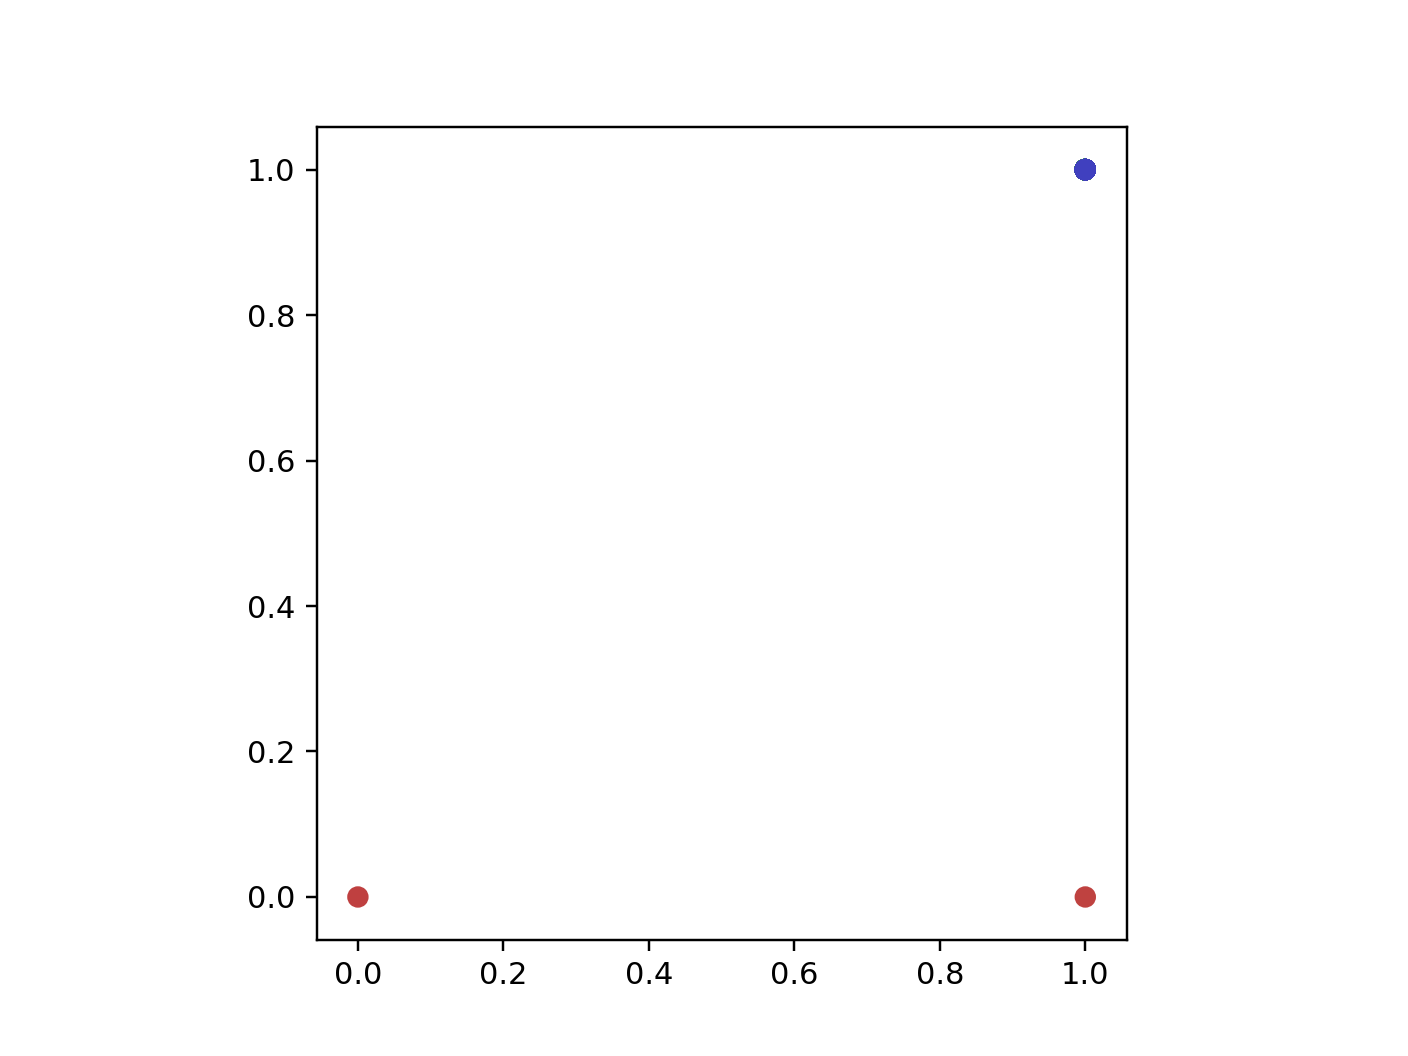

In [111]:
"""
name: "Orthogonal Steps",
    description:
      "Points related by mutually orthogonal steps. " +
      "Very similar to a random walk.",
    options: [
      {
        name: "Number Of Points",
        min: 20,
        max: 500,
        start: 50
      }
    ],
    generator: generators.orthoCurve
    
    name: "Orthogonal Steps",
    options: [{ name: "Number Of Points", start: 200 }]
"""

points = orthoCurve(200)
data = np.array(list(map(lambda point: point.coords, points)))
color = np.array(list(map(lambda point: point.color, points)))
print(data.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data[:, 0], data[:, 1], color=color)
ax.set_aspect('equal')
plt.show()

<IPython.core.display.Javascript object>


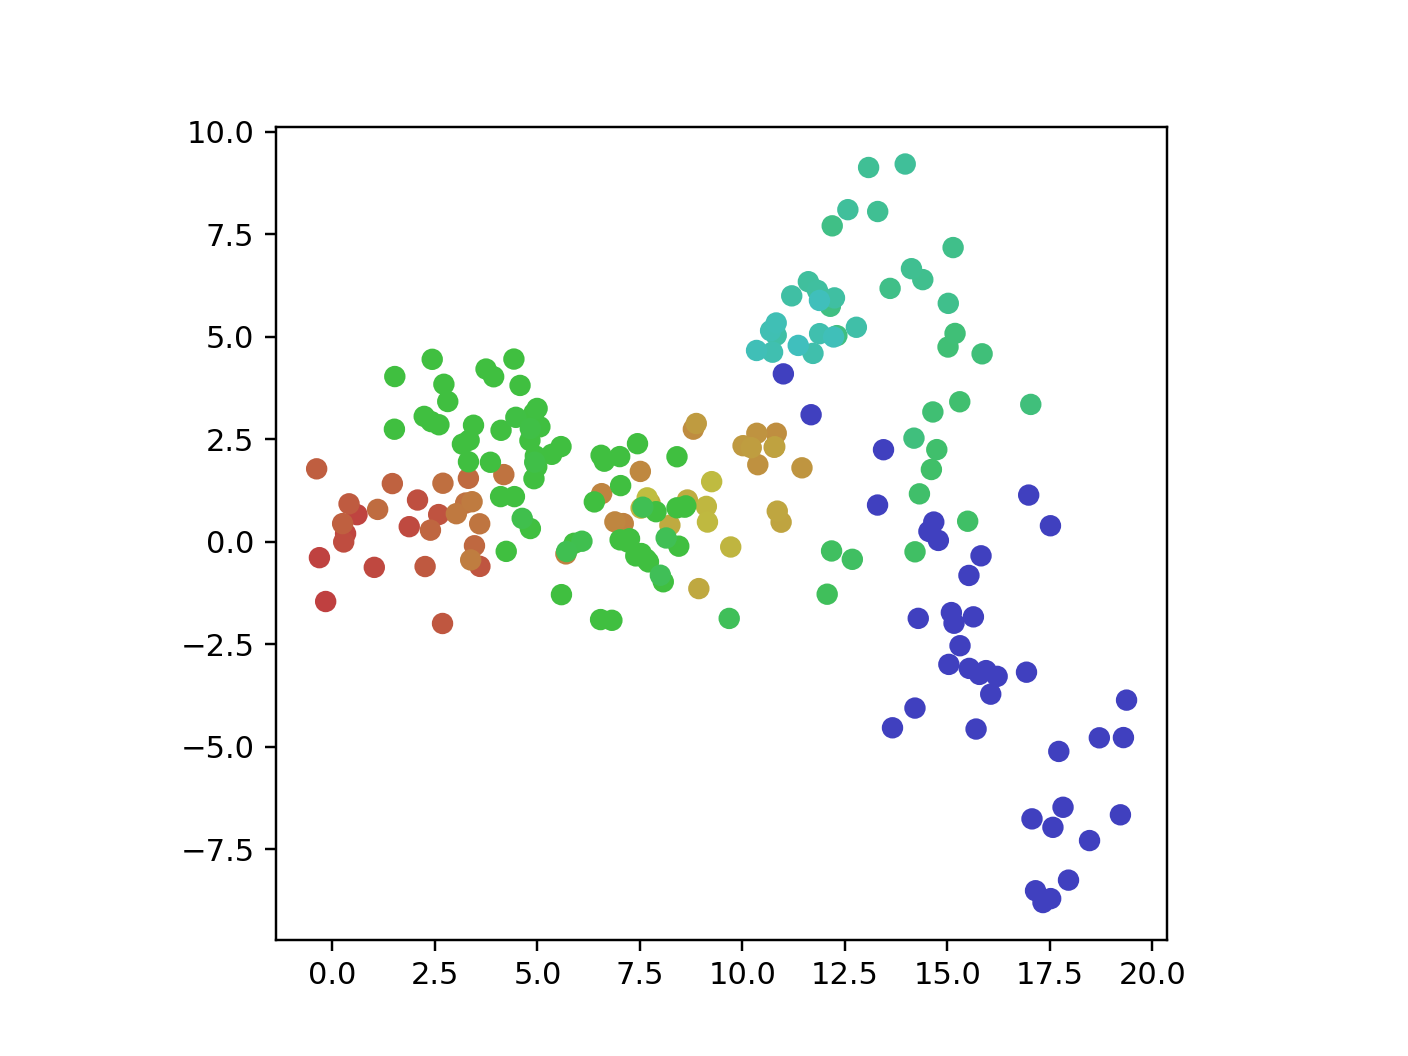

In [15]:
# name: "Random Walk",
#    options: [
#      { name: "Number Of Points", start: 200 },
#      { name: "Dimension", start: 100 }
points = randomWalk(200, 2)
data = np.array(list(map(lambda point: point.coords, points)))
color = np.array(list(map(lambda point: point.color, points)))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data[:, 0], data[:, 1], color=color)
ax.set_aspect('equal')
plt.show()

<IPython.core.display.Javascript object>


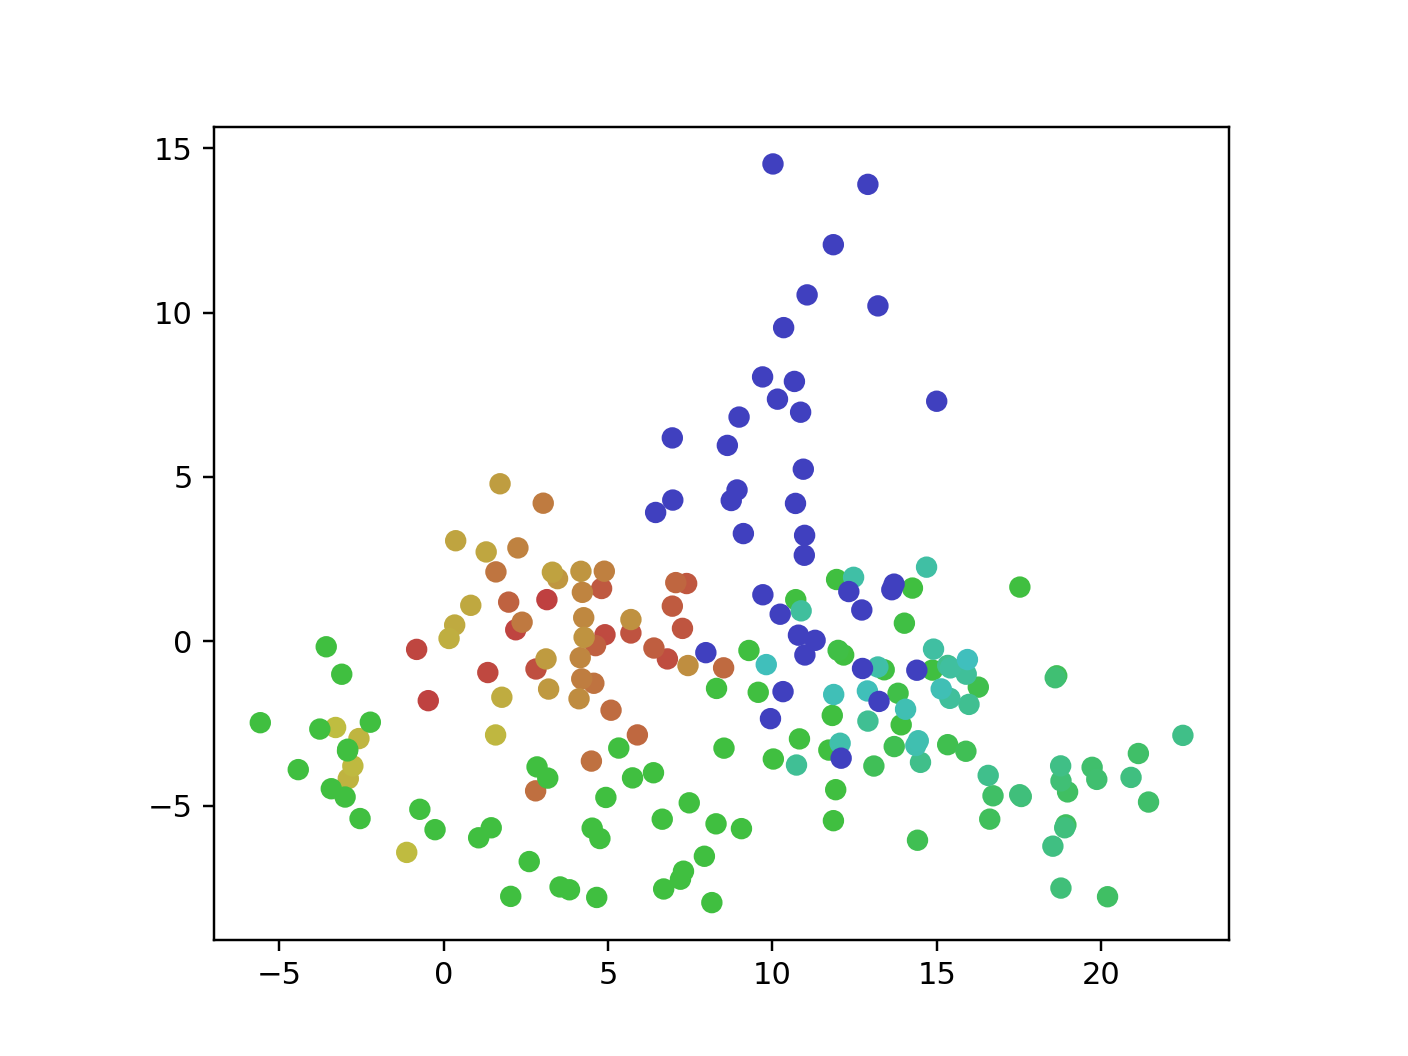

In [16]:
# name: "Random Jump",
#    options: [
#      { name: "Number Of Points", start: 200 },
#      { name: "Dimension", start: 100 }]
points = randomJump(200, 2)
data = np.array(list(map(lambda point: point.coords, points)))
color = np.array(list(map(lambda point: point.color, points)))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data[:, 0], data[:, 1], color=color)
ax.set_aspect('equal')
plt.show()

0.5
(200, 200)


<IPython.core.display.Javascript object>


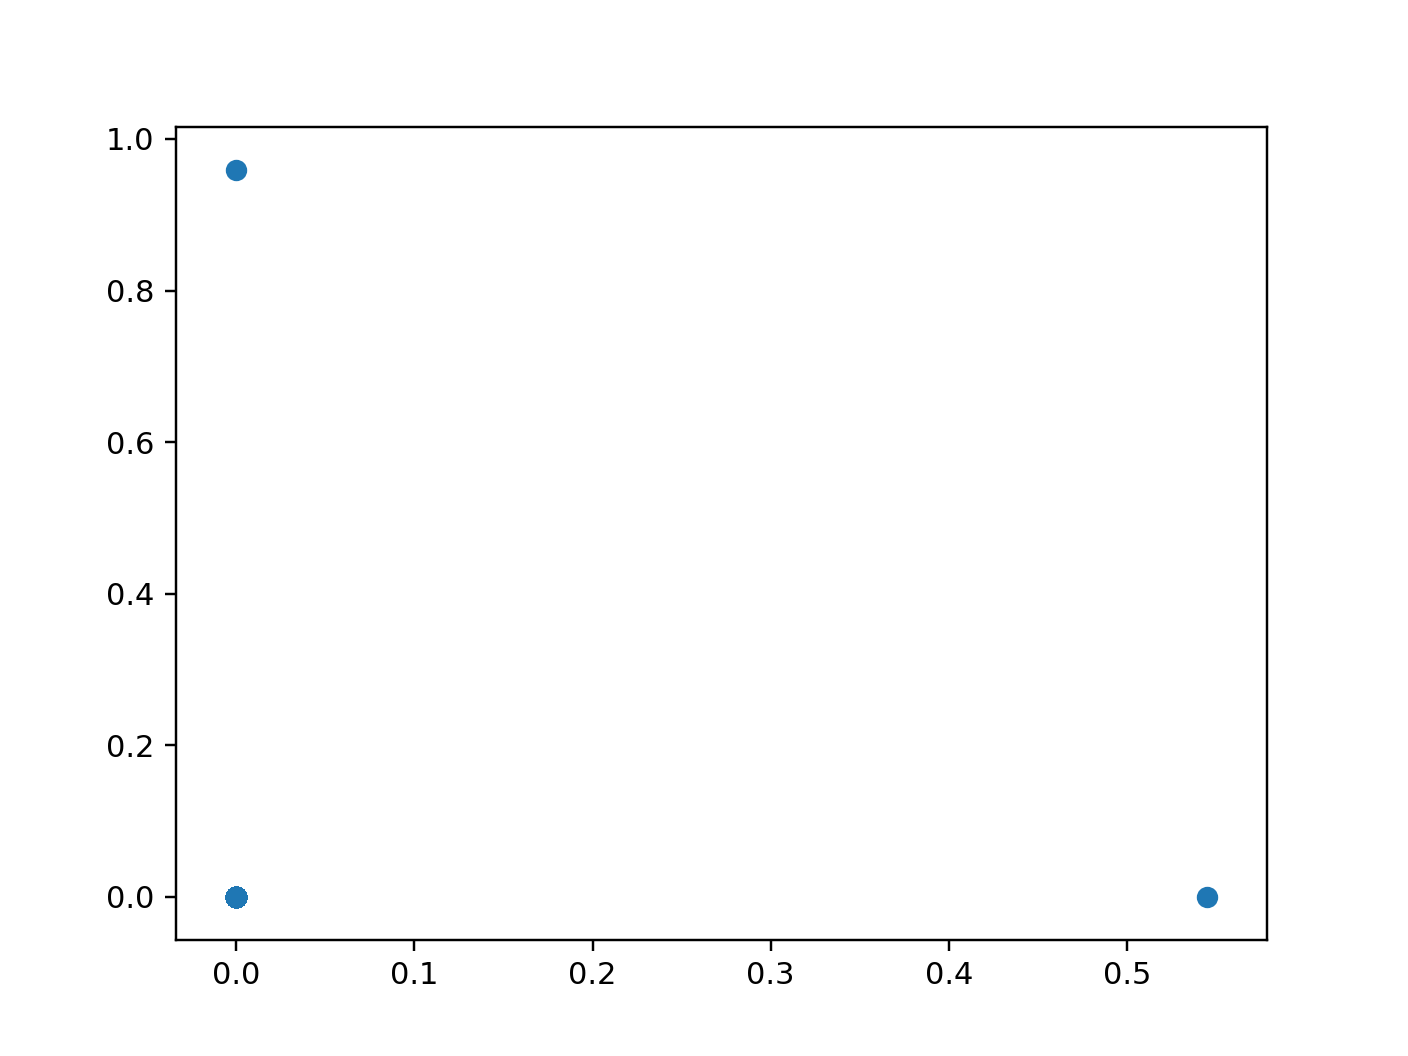

In [17]:
# 可視化の仕方が悪そう->200点生成すると200次元のデータセットができる（1点は大きさほぼ1(ノイズ付与)で1/200次元のデータとなる)
# name: "Equally Spaced",
#     description:
#       "A set of points, where distances between all pairs of " +
#       "points are the same in the original space.",
#     options: [
#       {
#         name: "Number Of Points",
#         min: 20,
#         max: 100,
#         start: 50
#       }
#     ],
#     generator: generators.simplexData
# name: "Equally Spaced",
#     options: [{ name: "Number Of Points", start: 200 }]
points = simplexData(200)
data = np.array(list(map(lambda point: point.coords, points)))
print(data.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data[:, 0], data[:, 1])   # plotされるのは３点で良い=>[1,0,...], [0, 1, ...], [0, 0, ...], [0, 0, ...]より[1,0][0,1][0,0]の３点にプロットされる
# ax.set_aspect('equal')
plt.show()

/Users/tsuno/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


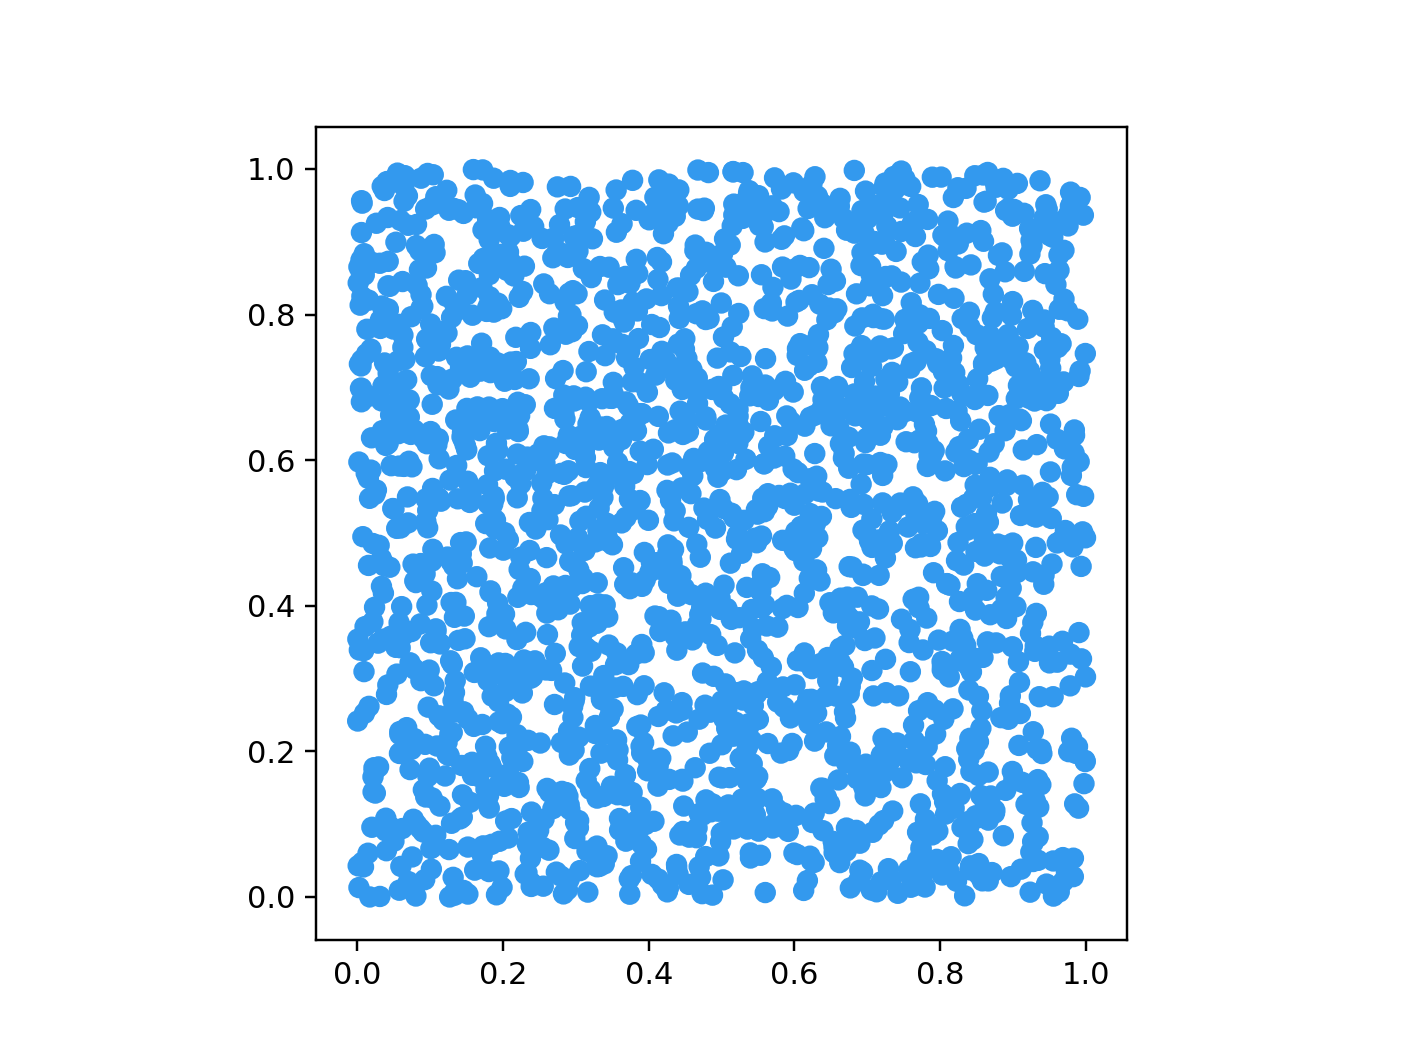

In [114]:
# name: "Uniform Distribution",
#     options: [
#       { name: "Number Of Points", start: 200 },
#       { name: "Dimensions", start: 10 }
points = cubeData(2000, 2)
data = np.array(list(map(lambda point: point.coords, points)))
color = np.array(list(map(lambda point: point.color, points)))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data[:, 0], data[:, 1], color=color)
ax.set_aspect('equal')
plt.show()

(200, 2)


<IPython.core.display.Javascript object>


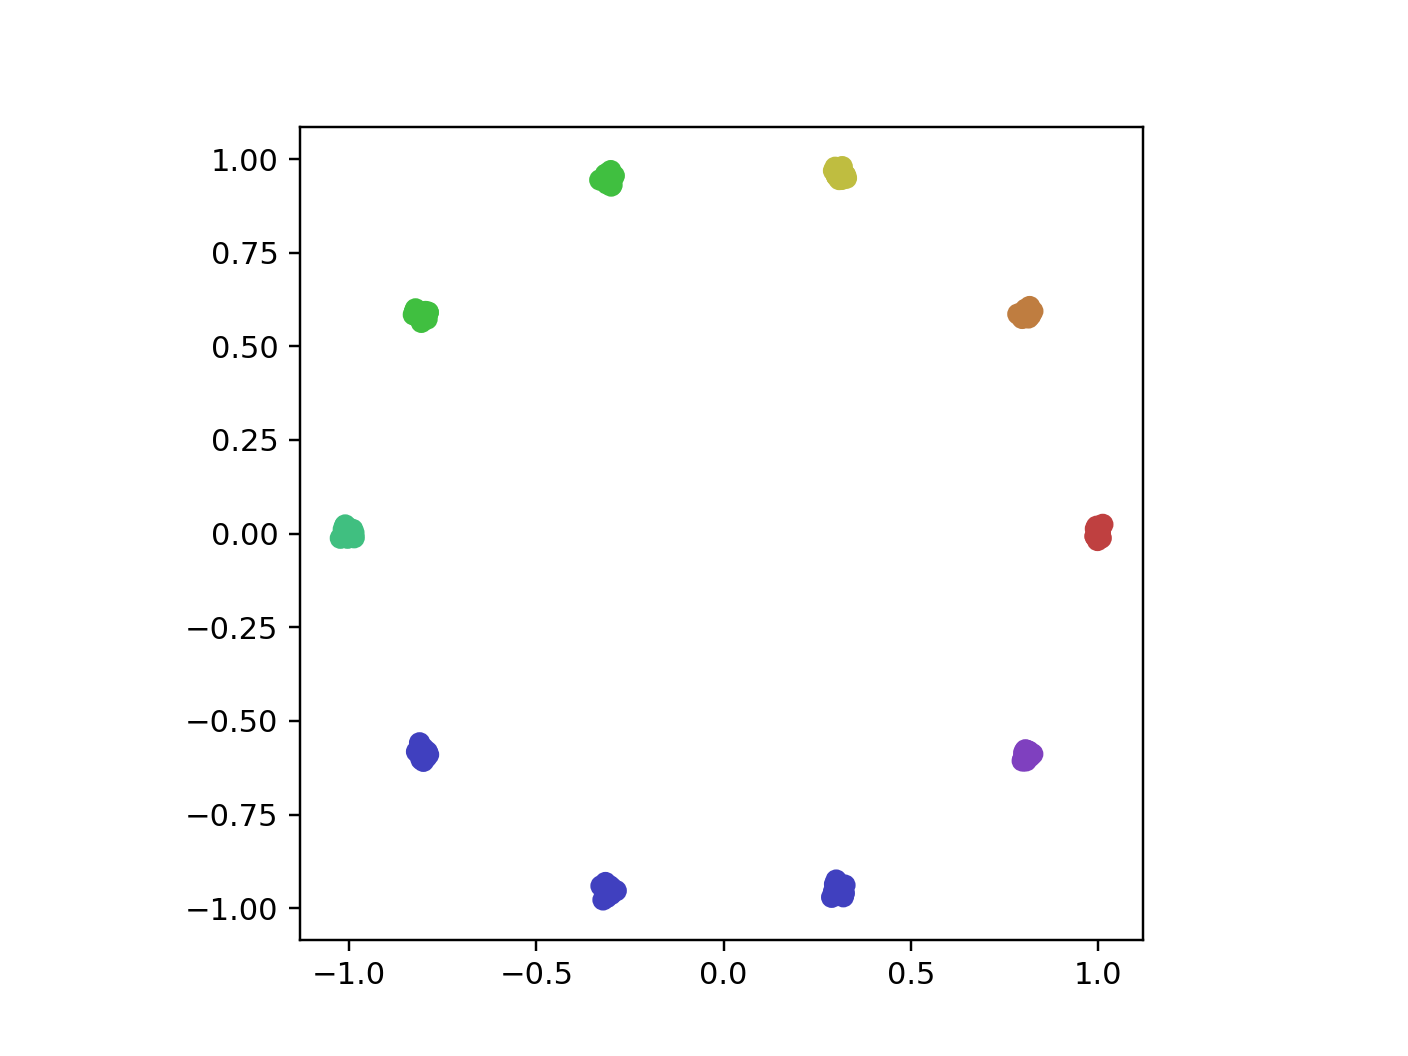

In [48]:
# randomCircleClusterData
# demo中にはなさそう
points = randomCircleClusterData(10)
data = np.array(list(map(lambda point: point.coords, points)))
color = np.array(list(map(lambda point: point.color, points)))
print(data.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data[:, 0], data[:, 1], color=color)
ax.set_aspect('equal')
plt.show()

(100, 2)


<IPython.core.display.Javascript object>


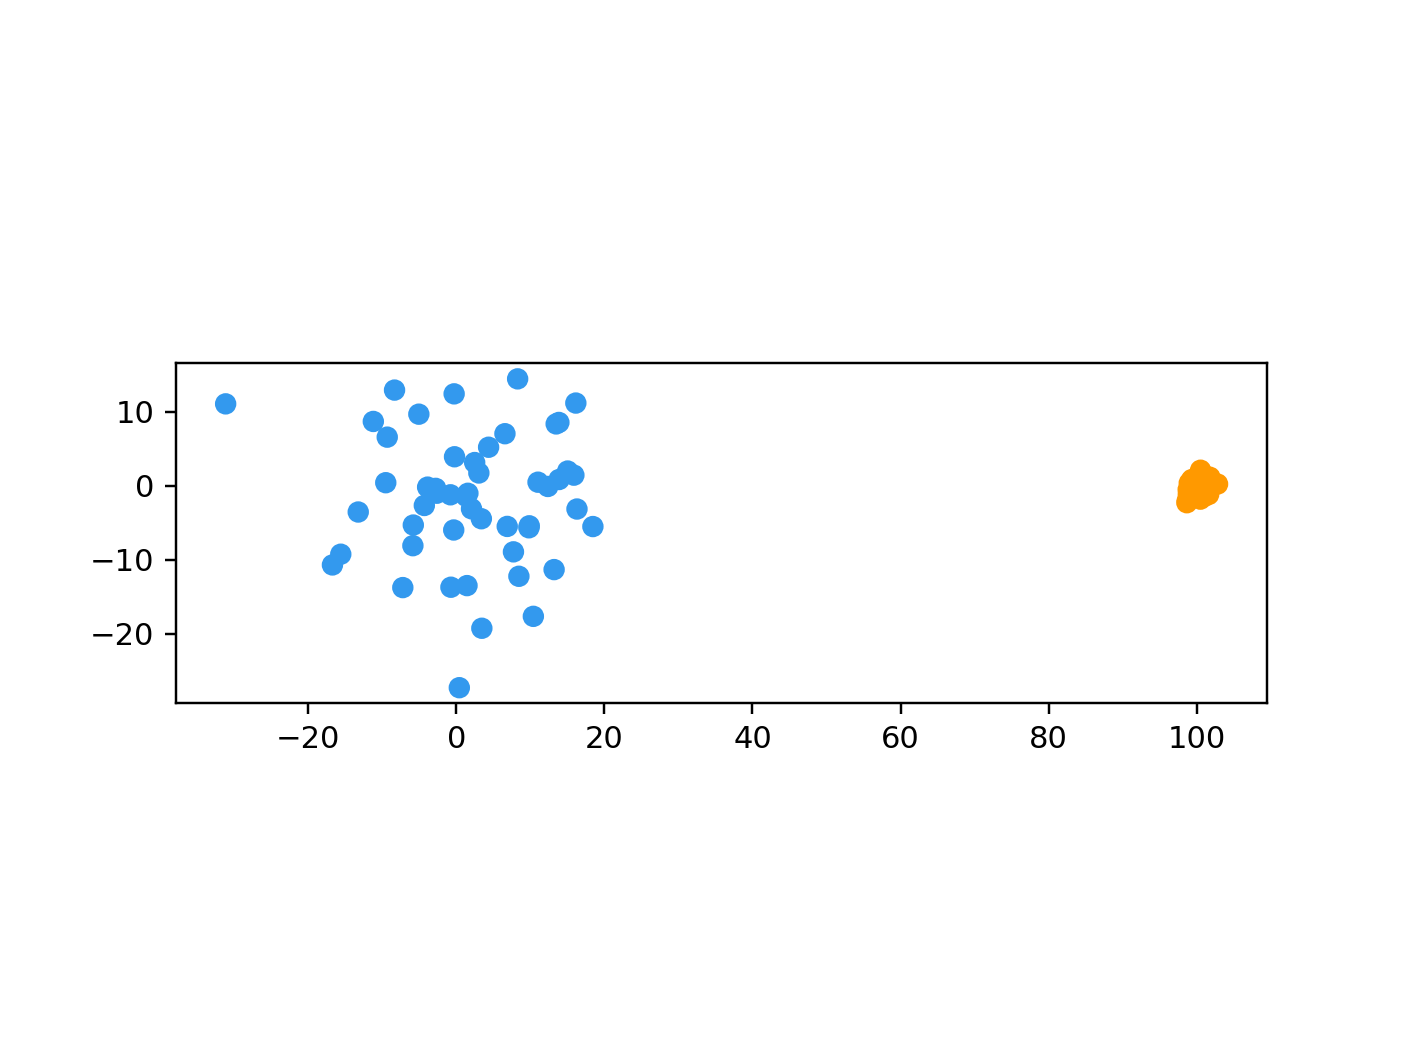

In [18]:
# twoDifferentClustersData2D
# demo中にはなさそう => 2次元専用
points = twoDifferentClustersData2D(50)
data = np.array(list(map(lambda point: point.coords, points)))
color = np.array(list(map(lambda point: point.color, points)))
print(data.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data[:, 0], data[:, 1], color=color)
ax.set_aspect('equal')
plt.show()

(600, 3)


<IPython.core.display.Javascript object>


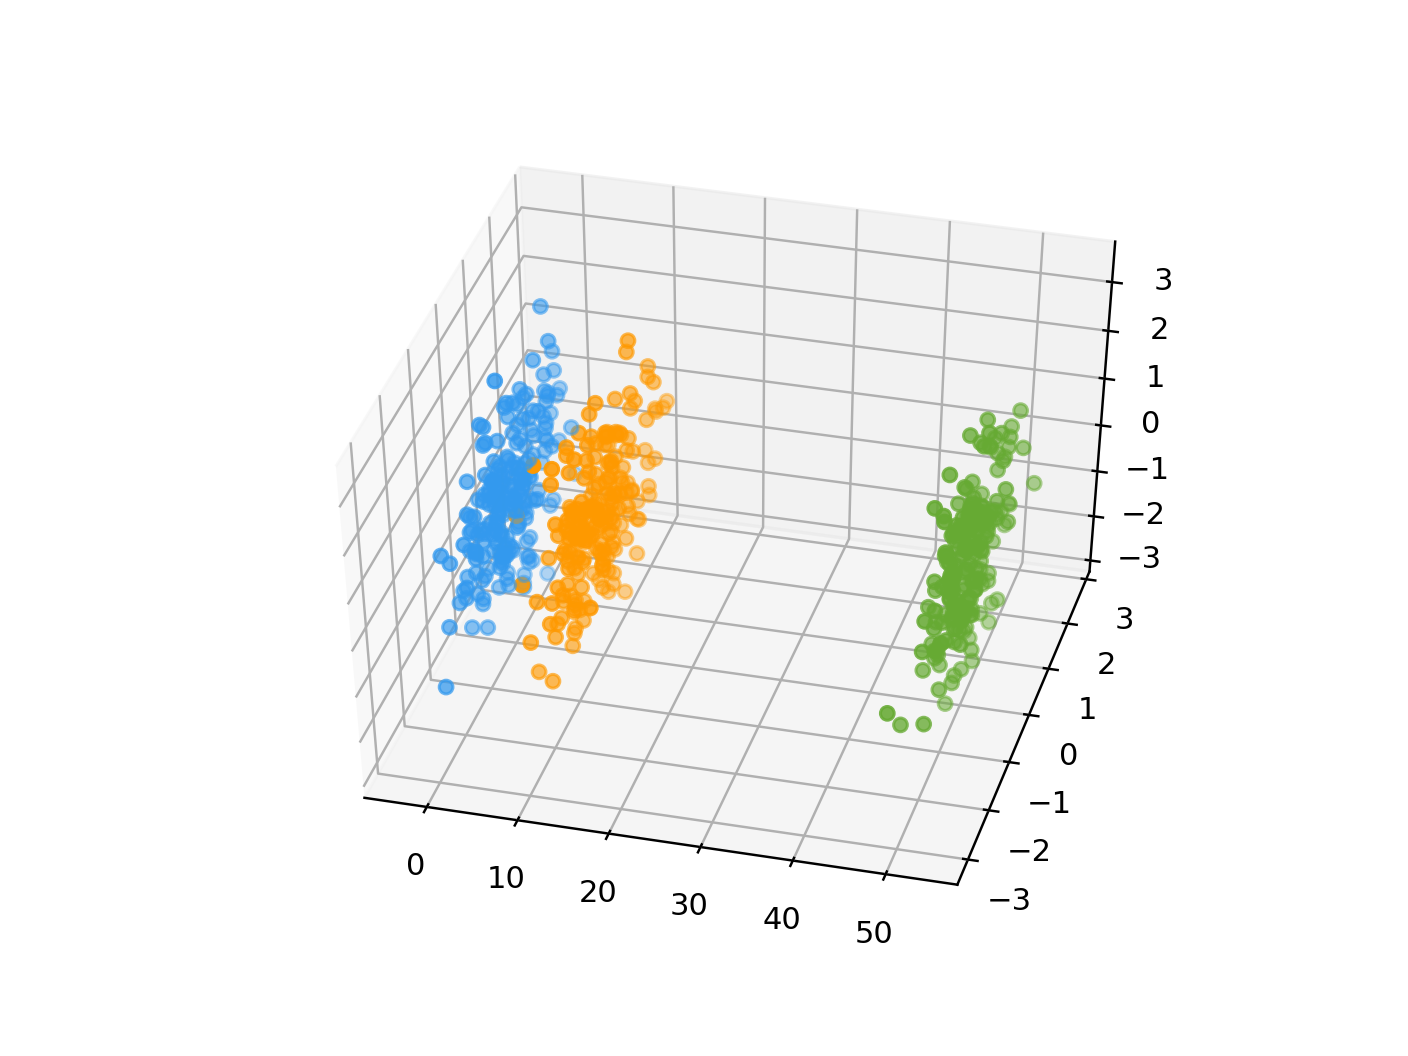

In [49]:
# threeClustersData
points = threeClustersData(200, 3)
data = np.array(list(map(lambda point: point.coords, points)))
color = np.array(list(map(lambda point: point.color, points)))
print(data.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], color=color)
# ax.set_aspect('equal')
plt.show()